# **Machine Learning Project: Predicting Hospital Readmissions **


## <a class="anchor" id="index">Index<br>

[<font color='#E8800A'>1 - Import libraries</font>](#topic01) <br>
[<font color='#E8800A'>2 - Define functions to Handle data</font>](#topic02) <br>
[<font color='#E8800A'>3 - Data exploration</font>](#topic03) <br>
[<font color='#E8800A'>4 - Data Preprocessing</font>](#topic04) <br>
[<font color='#E8800A'>5 - Algorythm Chains: Pipelines and Column Transformers</font>](#topic05) <br>
[<font color='#E8800A'>6 - Assessing several models with the data</font>](#topic06) <br>
[<font color='#E8800A'>7 - Optimized search for the ideal Hyperparameter</font>](#topic07) <br>
[<font color='#E8800A'>8 - Final Models and Prediction on Test Set</font>](#topic08) <br>

<a class="anchor" id="topic01" /><br>
## Step 1: Import libraries
[Back to Index](#index)

#### 1.1 Optionally install libraries

In [1]:
#!pip install yaml


#### 1.2 Import needed libraries


In [2]:
import os
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy.stats import randint

import sklearn
from sklearn import preprocessing
from scipy import stats # for chi squared
from scipy.stats import loguniform
from scipy.stats import chi2_contingency
from scipy.stats import entropy
from scipy.spatial import distance_matrix
from collections import Counter
import time, datetime

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_classif

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.datasets import make_classification

from matplotlib import pyplot

from sklearn.svm import SVR

import yaml

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


import warnings
warnings.filterwarnings('ignore')


#### 1.3 Define global variables that will control execution options throughout the notebook


In [3]:
g_verbose_mode = True
g_verbose_models = 3
g_random_state = 53
g_gen_pipeline_debug_files = False

target_var_BC = "readmitted_binary"
target_var_MC = "readmitted_multiclass"


k_data_path = "../data/"


dicParams = {}
dicParams["threshold_pct_on_nulls"] = 10
dicParams["knn_neighborhood"] = 5
dicParams["knn_weighs"] = "uniform"
dicParams["validation_size_BC"] = 0.25
dicParams["validation_size_MC"] = 0.25
dicParams["test_size_BC"] = 0.25
dicParams["test_size_MC"] = 0.25
dicParams["histograms_numlines"] = 4
dicParams["correl_threshold_BC"] = 0.01
dicParams["correl_threshold_MC"] = 0.01

dicParams["outlier_threshold_IQR_upper"] = 3
dicParams["outlier_threshold_IQR_lower"] = 3
dicParams["threshold_min_entropy"] = 0.01
dicParams["threshold_max_entropy"] = 5
dicParams["threshold_chi2_alpha"] = 0.05

dicParams["RepeatedStratifiedKFold_n_splits"] = 4
dicParams["RepeatedStratifiedKFold_n_repeats"] = 2


dicPreprocess = {}

           
with open("MLG36.yaml", 'r') as stream:
	try:
		dicPreprocess = yaml.safe_load(stream)
		listmaptonull = dicPreprocess["maptonull"]
		dicmapvalues = dicPreprocess["mapvalues"]

	except yaml.YAMLError as exc:
		print(exc)



split_method = RepeatedStratifiedKFold(n_splits = dicParams["RepeatedStratifiedKFold_n_splits"], 
                                       n_repeats=dicParams["RepeatedStratifiedKFold_n_repeats"], 
                                       random_state = g_random_state)




# Set the display option to show all columns
pd.set_option("display.max_columns", None)

set_config(display='diagram')


#### 1.4 Define global dataframes


In [4]:
X_train_BC, X_val_BC, X_trainval_BC, X_test_BC, X_train_MC, X_val_MC, X_trainval_MC, X_test_MC, df_data_exploration = None, None, None, None, None, None, None, None, None
y_train_BC, y_val_BC, y_trainbval_BC, y_test_BC, y_train_MC, y_val_MC, trainval_MC, y_test_MC = None, None, None, None, None, None, None, None
df_trainfile = None



#### 1.5 Define key variable lists

In [5]:
#Define lists to record the nature of each column

lstvars_todrop = []

lstvars_non_ordinal_cat = ["country", "race", "payer_code", "admission_type", "medical_specialty", "discharge_disposition", "admission_source"] # medical_specialty
lstvars_ordinal_cat     = ["weight", 'age']
lstvars_binary_cat      = ['gender', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds']    
lstvars_numerical       = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year',
       'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']


lstvars_targets = [target_var_BC, target_var_MC]
lstvars_categorical = lstvars_non_ordinal_cat + lstvars_ordinal_cat
lstvars_categorical_all = lstvars_non_ordinal_cat + lstvars_ordinal_cat + lstvars_binary_cat


## Step 2: Define functions to handle data
Define generic functions as a way to organize code and simplify more complex blocks of code<br>
<br> [Back to Index](#index)
<br><a class="anchor" id="topic02" /><br>





#### 2.1 Functions to print info on screen

In [6]:
def vprint(*print_params):
    '''Works the same way as print, but only actually outputs if global variable g_verbose_mode = True. Otherwise, nothing happens.
    '''
    if g_verbose_mode:
        print(*print_params)



def printElapsedTime(start, end):
    ''''This function prints the elapsed time in seconds between two moments passed as paremeters.'''
    elapsed = end - start
    print("Elapsed time: " + str(elapsed) + " seconds")



#### 2.2 Get data from the input files


In [7]:
def filepath(filename):
    ''' Return the name of the file to open, knowing the relative path and that it's a CSV file.'''
    return k_data_path + filename + ".csv"



def getdataframe_from_file(file_name):
    '''Receives a file name (withouth the .csv extension) and returns a dataframe with the contents of the file.
    The index is set to the encounter_id column.
    '''
    
    dataframe = pd.read_csv(filepath(file_name), sep=",")
    dataframe.set_index("encounter_id", inplace=True)

    # All strings will be converted to capitalized case and stripped of leading and trailing spaces
    for column in list( dataframe.select_dtypes(include=['object']).columns):
        dataframe[column] = dataframe[column].str.strip().str.capitalize()

	# Convert invalid expressions to NaN
    for expr in listmaptonull:
        dataframe.replace(expr, np.nan, inplace=True)

    return dataframe


#### 2.3 Input file initial handling
Open files, split them in train-val-test and invoque the preprocessing function


In [8]:

def preprocess():
    '''
    Opens the data file with the train, validation and test information
    Creates a dataframe for data exploration.
    Maps values based on YAML file.
    Creates dataframes for train, validation and test for both BC and MC, and a dataframe that combines train and validation, to use for cross-validation functions.
    '''
    
    global df_trainfile
    global X_train_BC, X_val_BC, X_trainval_BC, X_test_BC, X_train_MC, X_val_MC,  X_trainval_MC, X_test_MC, df_data_exploration
    global y_train_BC, y_val_BC, y_trainval_BC, y_test_BC, y_train_MC, y_val_MC, y_trainval_MC, y_test_MC

    
    # Get the train dataframe
    df_trainfile = getdataframe_from_file("train")

    #Copy of data, used for data exploration. Not used otherwise.
    df_data_exploration = df_trainfile.copy()


    # Map values based on YAML file. Optionally, rename column
    for df in [df_trainfile]:
        for dic in dicmapvalues:
            namevar = dic["name"]
            if namevar not in df.columns:
                vprint("Column", namevar, "not found in dataframe. Check the exact name and correct YAML file. Skipping...")
            else:
                values = dic["values"]
                df[namevar].replace(values, inplace=True)
                if "datatype" in dic.keys():
                    if dic["datatype"] == "int":
                        df[namevar] = df[namevar].astype(int)
                    elif dic["datatype"] == "float":
                        df[namevar] = df[namevar].astype(float)
                    elif dic["datatype"] == "bool":
                        df[namevar] = df[namevar].astype(bool)
                    elif dic["datatype"] == "str":
                        df[namevar] = df[namevar].astype(str)
                if "newname" in dic.keys():
                    if dic["newname"] != "" and dic["newname"] != dic["name"]:
                        newnamevar = dic["newname"]
                        df.rename(columns={namevar: newnamevar}, inplace=True)
    

    X_trainval_BC, X_test_BC, y_trainval_BC, y_test_BC = train_test_split(df_trainfile.drop(lstvars_targets, axis=1), df_trainfile[target_var_BC], test_size=dicParams["test_size_BC"], random_state=g_random_state, stratify=df_trainfile[target_var_BC])
    X_trainval_MC, X_test_MC, y_trainval_MC, y_test_MC = train_test_split(df_trainfile.drop(lstvars_targets, axis=1), df_trainfile[target_var_MC], test_size=dicParams["test_size_MC"], random_state=g_random_state, stratify=df_trainfile[target_var_MC])

    proport_val_size_BC = dicParams["validation_size_BC"] / (1 - dicParams["test_size_BC"])
    proport_val_size_MC = dicParams["validation_size_MC"] / (1 - dicParams["test_size_MC"])

    X_train_BC, X_val_BC, y_train_BC, y_val_BC = train_test_split(X_trainval_BC, y_trainval_BC, test_size=proport_val_size_BC, random_state=g_random_state, stratify=y_train_BC)
    X_train_MC, X_val_MC, y_train_MC, y_val_MC = train_test_split(X_trainval_MC, y_trainval_MC, test_size=proport_val_size_MC, random_state=g_random_state, stratify=y_train_MC)


    return
    


#### 2.4 Functions to test the performance of the models

In [9]:

def return_f1score(model, X, y):
    '''Given a model, a dataframe and a target variable, returns the f1 score for the model on that dataframe. Uses cross validation (split in 4).'''
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = 4)
    print("return_f1score n_scores=", n_scores)
    return n_scores



In [10]:

def return_scores(model, dataframe_X, dataframe_y):
    '''Given a model, a dataframe and a target variable, returns the scores for the model on that dataframe.'''

    n_scores = cross_validate(model, dataframe_X, dataframe_y, scoring = {"f1":"f1", "f1_weighted":"f1_weighted", "accuracy":"accuracy", "recall":"recall", "precision":"precision"}, cv = split_method, return_train_score=True)
    
    return n_scores, model



In [11]:
def myreturn_results(models, X, y, title, boxplot = []):
	'''
	Returns cross-validation scores for a list of models, given a dataframe and a target variable.
	Accepts a title, that's used to present in a chart with the results.
	boxplot is the list of metrics to plot: "test_f1", "train_f1", "test_f1_weighted", etc'''
	results, names = [],[]
	retvalues = []
	fittedmodels = {}
	if type(y) != pd.core.frame.DataFrame:
		df_y = pd.DataFrame(y, columns = ["target"])
	else:
		df_y = y.copy()

	for name, model in models.items():
		scores, model = return_scores(model, X, df_y)
		for scoreitem in boxplot:
			results.append(scores[scoreitem])
			names.append("{}\n{}\n{:.3f}".format(name, scoreitem, np.nanmean(scores[scoreitem])))

		mean_scores = {key: np.nanmean(value) for key, value in scores.items()}
		retvalues.append([name, mean_scores])
		fittedmodels[name] = model
		print("Mean scores,", name, ":", mean_scores)

	if boxplot != []:
		plt.figure(figsize=(15,7))
		plt.boxplot(results, labels = names, showmeans = True)
		plt.xticks(fontsize=10)
		plt.title(title)
		plt.show()
	return retvalues, fittedmodels


In [12]:
def myreturn_results_BC(models, X, y, title, boxplot = ["test_f1"]):
    '''Same as myreturn_results, but specific for binary classification.'''
    retvalues, fittedmodels = myreturn_results(models, X, y, title, boxplot=boxplot)
    return retvalues, fittedmodels



In [13]:
def myreturn_results_MC(models, X, y, title, boxplot = ["test_f1_weighted"]):
    '''Same as myreturn_results, but specific for multiclass classification.'''
    retvalues, fittedmodels = myreturn_results(models, X, y, title, boxplot=boxplot)
    return retvalues, fittedmodels


#### 2.5 Function to evaluate or models using an approach that is less sensitive to the split performed
Function receives a split_method (eg. KFold), a dataset, a target and a pipeline
It prints the average score of that pipeline for that dataset using the provided split method


In [14]:
def avg_score_BC(split_method,X,y, pipeline, p_average='binary'):
    '''avg_score receives a split_method (tipically, K_Fold), a data set, a target variable and an unfitted pipeline.
    The split_method is used to separate the dataset between train and validation. The pipeline's performance
    is measured for both train and validation data.
    The function prints the average score for both train and validation, and its difference.'''
    score_train = []
    score_val = []
    for train_index, val_index in split_method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        predictions_train = pipeline.predict(X_train)
        predictions_val = pipeline.predict(X_val)

        value_train = f1_score(predictions_train, y_train, average=p_average, pos_label='Yes')
        value_val = f1_score(predictions_val,y_val, average=p_average, pos_label='Yes')
        score_train.append(value_train)
        score_val.append(value_val)

    print('Train average score:' +  str(round(np.mean(score_train),3)) + '+/-' + str(round(np.std(score_train),3)))
    print('Val average score:' +  str(round(np.mean(score_val),3)) + '+/-' + str(round(np.std(score_val),3)))
    print('Overfitting abs(Train-Val):' +  str(round(abs(np.mean(score_train)-np.mean(score_val)),3)) )

In [147]:
def avg_final_score_BC(split_method,X,y, pipeline, p_average='binary'):
    '''avg_score receives a split_method (tipically, K_Fold), a data set, a target variable and an unfitted pipeline.
    The split_method is used to separate the dataset between train and test. The pipeline's performance
    is measured for both train and validation data.
    The function prints the average score for both train and test, and its difference.'''
    score_train = []
    score_test = []
    for train_index, test_index in split_method.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        predictions_train = pipeline.predict(X_train)
        predictions_test = pipeline.predict(X_test)

        value_train = f1_score(predictions_train, y_train, average=p_average, pos_label='Yes')
        value_test = f1_score(predictions_test,y_test, average=p_average, pos_label='Yes')
        score_train.append(value_train)
        score_test.append(value_test)

    print('Train average score:' +  str(round(np.mean(score_train),3)) + '+/-' + str(round(np.std(score_train),3)))
    print('Test average score:' +  str(round(np.mean(score_test),3)) + '+/-' + str(round(np.std(score_test),3)))
    print('Overfitting abs(Train-Test):' +  str(round(abs(np.mean(score_train)-np.mean(score_test)),3)) )

In [15]:
def avg_score_MC(split_method,X,y, pipeline, p_average='binary'):
    '''avg_score receives a split_method (tipically, K_Fold), a data set, a target variable and an unfitted pipeline.
    The split_method is used to separate the dataset between train and validation. The pipeline's performance
    is measured for both train and validation data.
    The function prints the average score for both train and validation, and its difference.'''
    score_train = []
    score_val = []
    for train_index, val_index in split_method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        predictions_train = pipeline.predict(X_train)
        predictions_val = pipeline.predict(X_val)

        value_train = f1_score(predictions_train, y_train, average='weighted')
        value_val = f1_score(predictions_val,y_val, average='weighted')
        score_train.append(value_train)
        score_val.append(value_val)

    print('Train average score:' +  str(round(np.mean(score_train),3)) + '+/-' + str(round(np.std(score_train),3)))
    print('Val average score:' +  str(round(np.mean(score_val),3)) + '+/-' + str(round(np.std(score_val),3)))
    print('Overfitting abs(Train-Val):' +  str(round(abs(np.mean(score_train)-np.mean(score_val)),3)) )


In [151]:
def avg_final_score_MC(split_method,X,y, pipeline, p_average='binary'):
    '''avg_score receives a split_method (tipically, K_Fold), a data set, a target variable and an unfitted pipeline.
    The split_method is used to separate the dataset between train and test. The pipeline's performance
    is measured for both train and test data.
    The function prints the average score for for both train and test, and its difference.'''
    score_train = []
    score_test = []
    for train_index, test_index in split_method.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        predictions_train = pipeline.predict(X_train)
        predictions_test = pipeline.predict(X_test)

        value_train = f1_score(predictions_train, y_train, average='weighted')
        value_test = f1_score(predictions_test,y_test, average='weighted')
        score_train.append(value_train)
        score_test.append(value_test)

    print('Train average score:' +  str(round(np.mean(score_train),3)) + '+/-' + str(round(np.std(score_train),3)))
    print('Test average score:' +  str(round(np.mean(score_test),3)) + '+/-' + str(round(np.std(score_test),3)))
    print('Overfitting abs(Train-Test):' +  str(round(abs(np.mean(score_train)-np.mean(score_test)),3)) )

#### 2.6 Function to show information on a dataframe

In [16]:
def df_info(dataframe, lstvars=None):
    '''
    Given a dataframe, presents a summary of the dataframe, including value distribution of its features.
    Also shows if each feature is present or not in a given list of variables. lstvars can be None, BC or MC
    '''
    temp = pd.DataFrame(index=dataframe.columns)
    
    temp["Datatype"]    = dataframe.dtypes
    temp["Not nulls"]   = dataframe.count()
    temp["Nulls"]       = dataframe.isnull().sum()
    temp["% Nulls"]     = (dataframe.isnull().mean())*100
    temp["Unique cnt"]  = dataframe.nunique()
    temp["Mean"]        = dataframe.mean()
    temp["StDev"]        = dataframe.std()
    temp["Min"]         = dataframe.min()
    temp["Q25"]         = dataframe.quantile(0.25)
    temp["Q50"]         = dataframe.quantile(0.5)
    temp["Q75"]         = dataframe.quantile(0.75)
    temp["Max"]         = dataframe.max()

    if lstvars == None:
        temp["non-ord cat"]    = ["X" if feat in lstvars_non_ordinal_cat    else "-" for feat in dataframe.columns]
        temp["ord cat"]        = ["X" if feat in lstvars_ordinal_cat        else "-" for feat in dataframe.columns]
        temp["bin cat"]        = ["X" if feat in lstvars_binary_cat         else "-" for feat in dataframe.columns]
        temp["num"]            = ["X" if feat in lstvars_numerical          else "-" for feat in dataframe.columns]
        temp["target"]         = ["X" if feat in lstvars_targets            else "-" for feat in dataframe.columns]
        temp["to drop"]        = ["X" if feat in lstvars_todrop             else "-" for feat in dataframe.columns]
    if lstvars == "BC":
        temp["non-ord cat BC"] = ["X" if feat in lstvars_non_ordinal_cat_BC else "-" for feat in dataframe.columns]
        temp["ord cat BC"]     = ["X" if feat in lstvars_ordinal_cat_BC     else "-" for feat in dataframe.columns]
        temp["bin cat BC"]     = ["X" if feat in lstvars_binary_cat_BC      else "-" for feat in dataframe.columns]
        temp["num BC"]         = ["X" if feat in lstvars_numerical_BC       else "-" for feat in dataframe.columns]
        temp["target BC"]      = ["X" if feat in lstvars_targets_BC         else "-" for feat in dataframe.columns]
        temp["To drop BC"]     = ["X" if feat in lstvars_todrop_BC          else "-" for feat in dataframe.columns]
    if lstvars == "MC":
        temp["non-ord cat MC"] = ["X" if feat in lstvars_non_ordinal_cat_MC else "-" for feat in dataframe.columns]
        temp["ord cat MC"]     = ["X" if feat in lstvars_ordinal_cat_MC     else "-" for feat in dataframe.columns]
        temp["bin cat MC"]     = ["X" if feat in lstvars_binary_cat_MC      else "-" for feat in dataframe.columns]
        temp["num MC"]         = ["X" if feat in lstvars_numerical_MC       else "-" for feat in dataframe.columns]
        temp["target MC"]      = ["X" if feat in lstvars_targets_MC         else "-" for feat in dataframe.columns]
        temp["To drop MC"]     = ["X" if feat in lstvars_todrop_MC          else "-" for feat in dataframe.columns]

    return temp


#### 2.7 Function to remove features from a dataframe and from variable lists, ignoring if they're not present


In [17]:

def remove_features_BC( ):
	'''
	Removes the features in lstvars_todrop_BC from the dataframes X_train_BC, X_val_BC, X_test_BC, X_train_val_BC
	and also from the generic lstvars_*_BC lists
	'''
	global X_train_BC, X_test_BC, X_val_BC, X_trainval_BC
	global lstvars_non_ordinal_cat_BC, lstvars_ordinal_cat_BC, lstvars_binary_cat_BC, lstvars_categorical_BC, lstvars_numerical_BC, lstvars_todrop_BC

	for df in [X_train_BC, X_val_BC, X_trainval_BC, X_test_BC]:
		for var in lstvars_todrop_BC:
			if var in df.columns:
				df.drop(var, axis=1, inplace=True)

	lstvars_non_ordinal_cat_BC = [x for x in lstvars_non_ordinal_cat_BC if x not in lstvars_todrop_BC]
	lstvars_ordinal_cat_BC     = [x for x in lstvars_ordinal_cat_BC if x not in lstvars_todrop_BC] 
	lstvars_binary_cat_BC      = [x for x in lstvars_binary_cat_BC if x not in lstvars_todrop_BC]
	lstvars_categorical_BC     = [x for x in lstvars_categorical_BC if x not in lstvars_todrop_BC]
	lstvars_numerical_BC 	    = [x for x in lstvars_numerical_BC if x not in lstvars_todrop_BC]
	
	lstvars_categorical_all_BC =  lstvars_categorical_BC + lstvars_binary_cat_BC
	lstvars_todrop_BC 		    = []


	


In [18]:

def remove_features_MC():
	'''
	Removes the features in lstvars_todrop_MC from the dataframes X_train_MC, X_val_MC, X_test_MC, X_train_val_MC
	and also from the generic lstvars_*_MC lists
	'''
	global X_train_MC, X_test_MC, X_val_MC, X_trainval_MC
	global lstvars_non_ordinal_cat_MC, lstvars_ordinal_cat_MC, lstvars_binary_cat_MC, lstvars_categorical_MC, lstvars_numerical_MC, lstvars_todrop_MC

	for df in [X_train_MC, X_val_MC, X_trainval_MC, X_test_MC]:
		for var in lstvars_todrop_MC:
			if var in df.columns:
				df.drop(var, axis=1, inplace=True)

	lstvars_non_ordinal_cat_MC = [x for x in lstvars_non_ordinal_cat_MC if x not in lstvars_todrop_MC]
	lstvars_ordinal_cat_MC     = [x for x in lstvars_ordinal_cat_MC if x not in lstvars_todrop_MC] 
	lstvars_binary_cat_MC      = [x for x in lstvars_binary_cat_MC if x not in lstvars_todrop_MC]
	lstvars_categorical_MC     = [x for x in lstvars_categorical_MC if x not in lstvars_todrop_MC]
	lstvars_numerical_MC 	   = [x for x in lstvars_numerical_MC if x not in lstvars_todrop_MC]
	lstvars_categorical_all_MC = lstvars_categorical_MC + lstvars_binary_cat_MC
	lstvars_todrop_MC 		   = []


#### 2.8 Calculate the entropy in a data series
A feature with extremely low or zero entropy is uninteresting as a predictor

In [19]:
def entropy_info(series_to_eval):
    '''Given a series, returns the entropy of the series.'''
    local_series = series_to_eval.copy()
    local_series.fillna('Unknown', inplace=True)
    value_counts = local_series.value_counts()
    entr_vals = value_counts / len(local_series)
    return entropy(entr_vals)


#### 2.9 Change outliers to match the top-limit value for the category


In [20]:
def set_interval_feature_val( list_dataframes, feature, maxlimit=None, maxvalue=None, minlimit=None, minvalue=None, verbose=False):
    '''
    This function receives a list of dataframes, a feature name, and optionally, a maxlimit, a maxvalue, a minlimit and a minvalue.
    If maxlimit is provided, all values above maxlimit are changed to maxvalue.
    If minlimit is provided, all values below minlimit are changed to minvalue.
    Either maxlimit or minlimit must be provided.
    '''
    if maxlimit == minlimit:
        maxlimit += 1
    if maxvalue==None:
        maxvalue = maxlimit
    if minvalue==None:
        minvalue = minlimit
    for dataframe in list_dataframes:
        newvalues = dataframe[feature].copy()

        df_antes = dataframe.copy()
        df_antes.rename(columns={feature:feature+" (before)"}, inplace=True)
        if verbose:
            print("{} values above {} in feature {} changed to a ceiling of {} and below {} changed to a floor of {}.".format(newvalues.loc[newvalues>maxlimit].count(), maxlimit, feature, maxvalue, minlimit, minvalue))
        if maxlimit != None:
            newvalues.loc[newvalues>maxlimit] = maxvalue
        if minlimit != None:
            newvalues.loc[newvalues<minlimit] = minvalue
        dataframe[feature] = newvalues
        
        df_antes = pd.concat([df_antes, dataframe[feature]], axis=1)
    


#### 2.10 Debug Class and methods for use in the pipeline

Classes and functions used for debugging the transformation inside a pipeline


In [21]:
# Classes and functions used for debugging the transformation inside a pipeline


class Debug( TransformerMixin, BaseEstimator):
        
    def transform(self, X):
        print(">>> transforming X of type ", type(X))
        return X

    def fit(self, X, y=None, **fit_params):
        print(">>> fitting X of type ", type(X))
        vprint("*   Debug.fit() called")
    
        vprint("*  ", self)
        if type(X) == pd.core.frame.DataFrame:
            vprint(X.head(4))
        else:
            vprint(X[0:4])

        
        return self




def Xtofile(X, prefix):
	'''Saves a dataframe or numpy.ndarray to a file.'''
	if g_gen_pipeline_debug_files == True:
		xx = X.copy()
		if type(xx) == pd.core.frame.DataFrame:
			if len(xx) > 20000:
				xx["target"] = y_train_BC
				xx.to_csv("output/" + prefix + "_df_X_train_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv")
			else:
				xx["target"] = y_val_BC
				xx.to_csv("output/" + prefix + "_df_X_val_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv")
		else:
			# # Add column with target variable to numpy.ndarray
			if xx.shape[1] > 20000:
				np.savetxt("output/" + prefix + "_np_X_train_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv", X, delimiter=",", fmt="%s")
				np.savetxt("output/" + prefix + "_np_X_train_target_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv", y_train_BC, delimiter=",", fmt="%s")
			else:
				np.savetxt("output/" + prefix + "_np_X_val_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv", X, delimiter=",", fmt="%s")
				np.savetxt("output/" + prefix + "_np_X_val_target_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv", y_val_BC, delimiter=",", fmt="%s")


class Debug( TransformerMixin, BaseEstimator):
	def transform(self, X):
		Xtofile(X, "model_TRN1")
		return X
		
	def fit(self, X, y=None, **fit_params):
		Xtofile(X, "model_FIT1")
		return self

class colDebug( TransformerMixin, BaseEstimator):
    def transform(self, X):
        Xtofile(X, "col_TRN")
        return X

    def fit(self, X, y=None, **fit_params):
        return self



#### 2.11 Visualizations

##### 2.11.1 ChartBoxPlots

In [22]:
def chartBoxPlots( features, data, title):
    '''Given a list of features and a dataframe, presents a boxplot for each feature.'''
    
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each box plot 
    for ax, feat in zip(axes.flatten(), features): 
        sns.boxplot(x=data[feat], ax=ax, palette=[ '#b4d2b1', '#568f8b', '#1d4a60','#cd7e59', '#ddb247', '#d15252'])

    # Layout
    # Add a centered title to the figure:
    plt.suptitle(title, fontsize=26)
    plt.show()


#### 2.11.2 Present percentages as bars

In [23]:
def plot_class_percentages(data, column_name, colors=None):
    '''Given a list of features, presents the percentage of each class in a bar chart.'''
    
    if colors is None:
        colors = sns.color_palette("Blues", n_colors=len(data[column_name].unique()))

    class_percentages = data[column_name].value_counts(normalize=True) * 100

    # Plotting
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=class_percentages.index, y=class_percentages.values, palette=colors)

    
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Percentage of Observations', fontsize=14)
    plt.title(f'Distribution of {column_name}', fontsize=16)

    
    for i, percentage in enumerate(class_percentages):
        ax.text(i, percentage + 1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)


    plt.yticks(fontsize=12)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

    
    plt.tight_layout()
    plt.show()


#### 2.12 Calculate feature importance using Chi^2

In [24]:
def get_independent_cats_chi2(X,target_var_name,alpha=dicParams["threshold_chi2_alpha"]):
    '''
    This function receives a dataframe (with categorical features + a target variable), the name of the target variable and a threshold value.
    It returns a list of the categorical variables that are not independent of the target variable, based on the threshold.
    '''
    lst = []
    testindep_targ = X[target_var_name]
    testindep_data = X.drop([target_var_name], axis=1)

    for var in testindep_data:
        dfObserved = pd.crosstab(testindep_targ,testindep_data[var])
        chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
        dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
        if p<alpha:
            result="{0} is IMPORTANT for Prediction".format(var)
        else:
            lst.append(var)
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
        vprint(result)
    return lst


#### 2.13 Pipeline functions


In [25]:
def build_pipeline(columnTransformer, classifier):
    '''Receives a columnTransformer and a classifier and returns a pipeline with those two steps.'''
    return Pipeline(steps=[('preprocessor', columnTransformer), ('classifier', classifier)])


#### 2.14 Return the best model's name based on a list of results and on a metric name

In [26]:
def get_best_model_name_by_metric(dic_results, metric_name):
	'''
	This function receives a dictionary of results (dic_results) and a metric name.
	It returns the name of the model that has the best value for the metric.
	Ex: get_best_model_name_by_metric(dic_results, "f1_test") returns "model1"
	The list of results is in the format that is returned from function myreturn_results_BC or myreturn_results_MC
	'''
	topmetric = np.nan
	topmodel = np.nan
	for model in dic_results:
		model_name = model[0]
		model_results = model[1]
		if metric_name in model_results.keys():
			metric_result = model_results[metric_name]
			if not np.isnan(metric_result):
				if np.isnan(topmetric):
					topmetric = metric_result
					topmodel = model_name
				elif metric_result > topmetric:
					topmetric = metric_result
					topmodel = model_name
	return topmodel


#### 2.15 Filter features to remove in selection

In [27]:
def filter_values(list_big, list_categorical, list_numeric):
    '''Filters values in list_big according to criteria.
    This is used for deciding what features to drop, based on the number of occurrences of each value.
    (Each occurrence corresponds to one test that recommended dropping the feature.)'''
    # Count occurrences in list_big
    counts = Counter(list_big)
    
    # Set to keep track of values already added
    added_values = set()
    
    # Filter values according to criteria
    filtered_values = []
    for value in list_big:
        if (value in list_categorical and counts[value] >= 1 and value not in added_values):
            filtered_values.append(value)
            added_values.add(value)
        elif (value in list_numeric and counts[value] >= 2 and value not in added_values):
            filtered_values.append(value)
            added_values.add(value)
    
    return filtered_values

<a class="anchor" id="topic03" /> <br>
## Step 3 - Data exploration
[Back to Index](#index)

### 3.1 Load data from the files provided, and "preprocess" them

Preprocessing includes the operations that are common to all datasets - train, validation and test.

In [28]:
preprocess()


#### 3.2 Basic Data Analysis

**Summary of the Dataframe**<br>
I check the nulls and its percentage per feature, count unique values, the mean, the min, max and the percentiles 25, 50, 75, and wether the feature is referenced in the lists of features

In [29]:
df_info(X_train_MC)

,Datatype,Not nulls,Nulls,% Nulls,Unique cnt,Mean,StDev,Min,Q25,Q50,Q75,Max,non-ord cat,ord cat,bin cat,num,target,to drop
country,object,35618,0,0.000000,1,NaN,NaN,Usa,NaN,NaN,NaN,Usa,X,-,-,-,-,-
patient_id,int64,35618,0,0.000000,30229,5.423500e+07,3.877312e+07,135,23378976.0,45291091.5,87548535.0,189502619,-,-,-,-,-,-
race,object,33015,2603,7.308103,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,-,-,-,-,-
isfemale,float64,35617,1,0.002808,2,5.402476e-01,4.983845e-01,0.0,0.0,1.0,1.0,1.0,-,-,-,-,-,-
agegroup,float64,33799,1819,5.106968,10,6.109530e+00,1.598813e+00,0.0,5.0,6.0,7.0,9.0,-,-,-,-,-,-
weightgroup,float64,1172,34446,96.709529,8,2.940273e+00,1.055998e+00,0.0,2.0,3.0,4.0,7.0,-,-,-,-,-,-
payer_code,float64,21538,14080,39.530574,16,7.087891e+00,3.570609e+00,0.0,6.0,7.0,7.0,16.0,X,-,-,-,-,-
outpatient_visits_in_previous_year,int64,35618,0,0.000000,29,3.595373e-01,1.243494e+00,0,0.0,0.0,0.0,42,-,-,-,X,-,-
emergency_visits_in_previous_year,int64,35618,0,0.000000,25,1.945084e-01,8.558128e-01,0,0.0,0.0,0.0,42,-,-,-,X,-,-
inpatient_visits_in_previous_year,int64,35618,0,0.000000,20,6.380763e-01,1.274268e+00,0,0.0,0.0,1.0,19,-,-,-,X,-,-


#### 3.3 Graphic Data Analysis

#### 3.3.1 Univariate Analysis

*Numeric Features, Histograms*

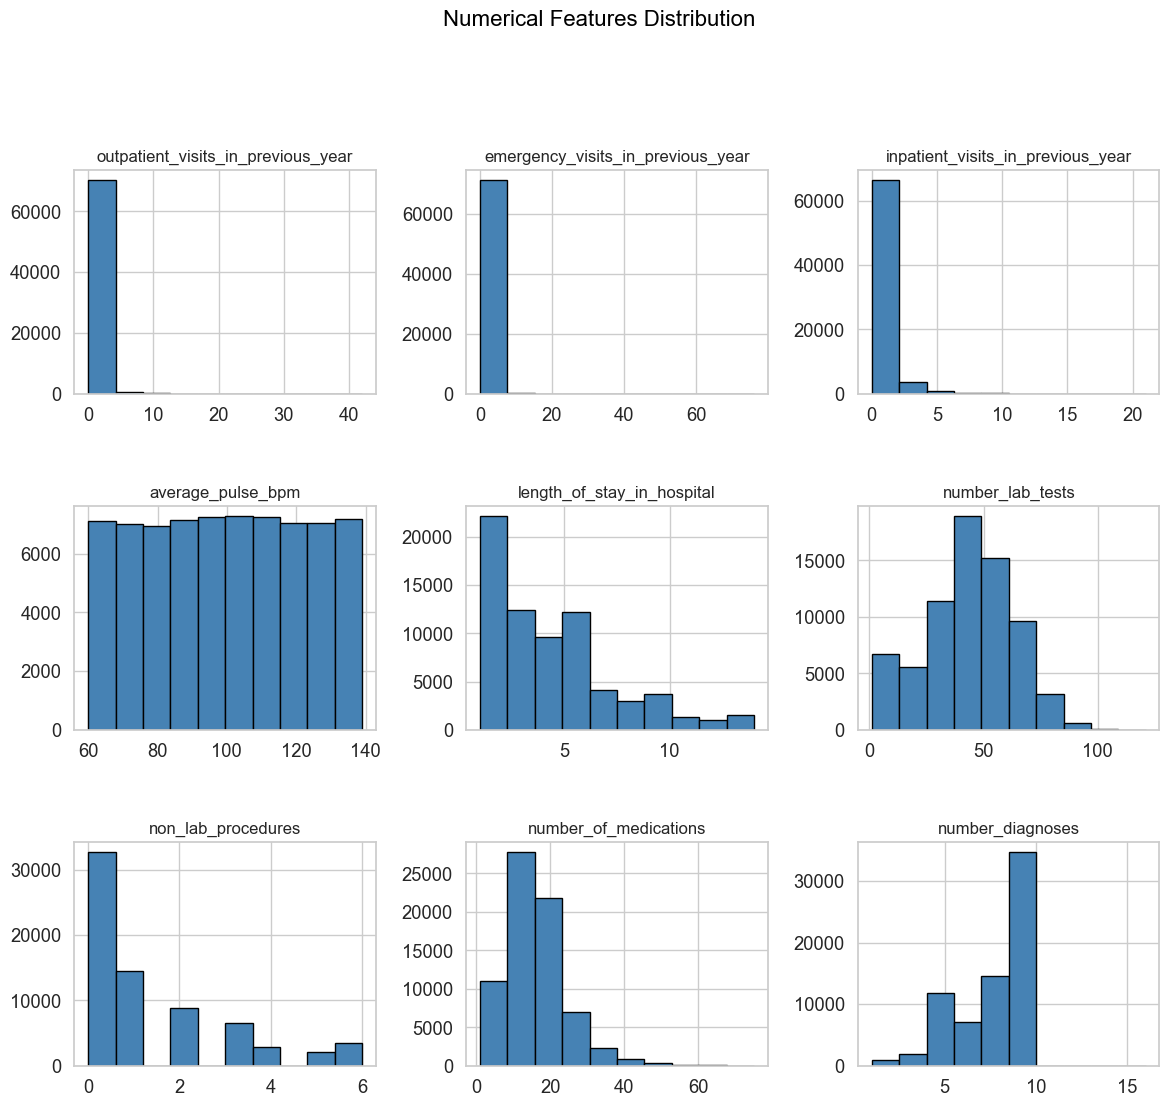

In [30]:
sns.set(style="whitegrid", font_scale=1.2)  
fig = plt.figure(figsize=(14, 16))  
fig.suptitle('Numerical Features Distribution', fontsize=16, color='black')

grid_layout = (4, 3)
i = 1

for column in lstvars_numerical:
    ax = fig.add_subplot(*grid_layout, i)
    df_data_exploration[column].plot(kind='hist', ax=ax, color='#4682B4', edgecolor='black')
    ax.set_title(column, fontsize=12)
    ax.set_ylabel("")
    i += 1

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


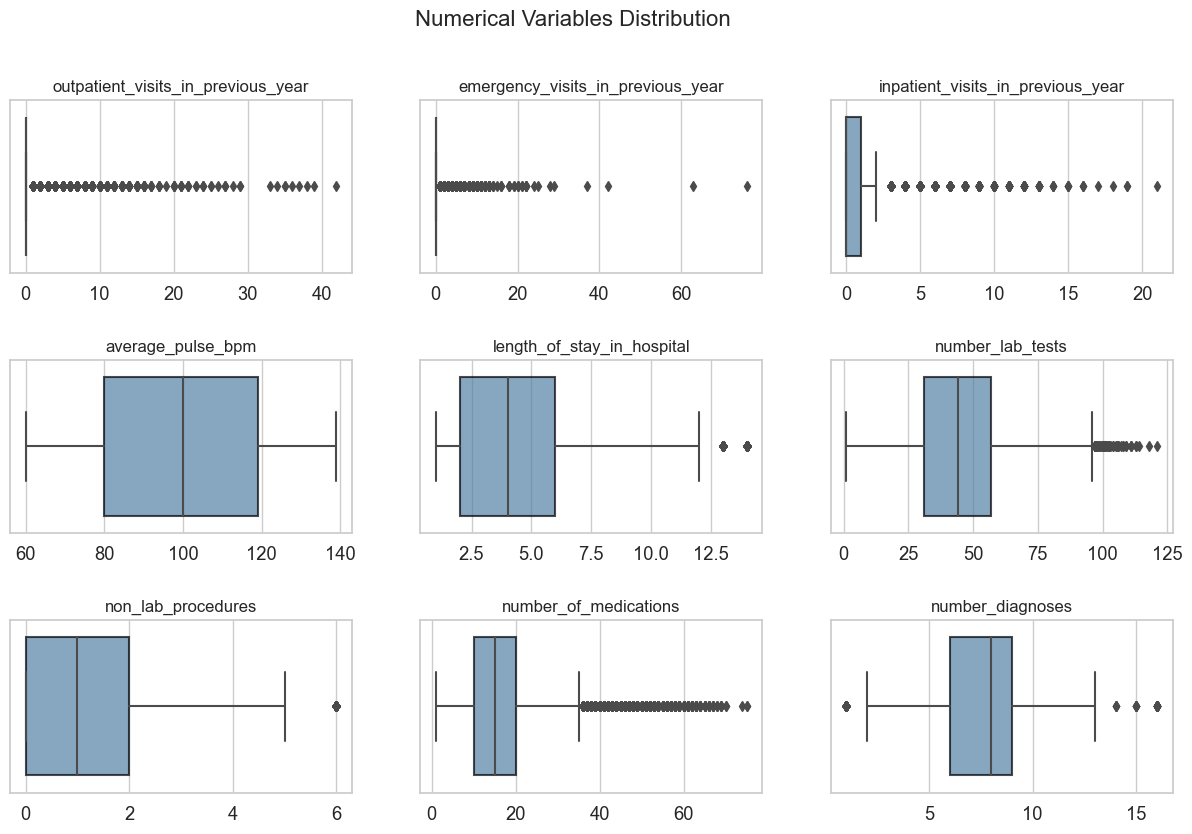

In [31]:
num_cols = 3
num_rows = (len(lstvars_numerical) - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_cols*num_rows))  
fig.subplots_adjust(hspace=0.5)  

for i, column in enumerate(lstvars_numerical):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    
    sns.boxplot(data=df_data_exploration, x=column, color='#4682B4', ax=ax, orient='v', boxprops=dict(alpha=0.7, edgecolor='black'))
    
    ax.set_xlabel('')
    ax.set_title(column, fontsize=12)  
    ax.xaxis.set_label_coords(0.5, -0.15)


for i in range(len(lstvars_numerical), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

fig.suptitle('Numerical Variables Distribution', fontsize=16)
plt.show()


*Binary Features - Bar charts*

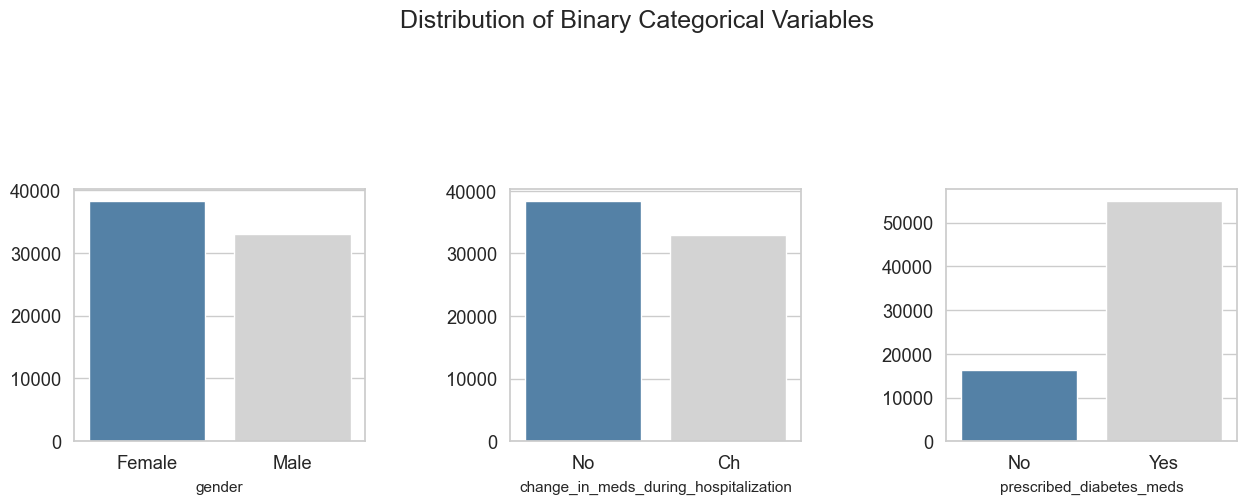

In [32]:
sns.set(style="whitegrid", font_scale=1.2)  
fig = plt.figure(figsize=(15, 18))

for i, column in enumerate(lstvars_binary_cat):
    sub = fig.add_subplot(4, 3, i + 1)
    chart = sns.countplot(data=df_data_exploration, x=column, palette=['#4682B4','#D3D3D3'] )
    sub.set_ylabel("")
    sub.set_xlabel("")
    sub.xaxis.set_label_coords(0.5, -0.1)
    
    # Setting titles at the bottom
    sub.set_title(column, fontsize=11, y=-0.23)  
  

plt.subplots_adjust(hspace=0.5, wspace=0.5)


fig.suptitle('Distribution of Binary Categorical Variables', fontsize=18)

plt.show()


*Categorical Features - Bar Charts*

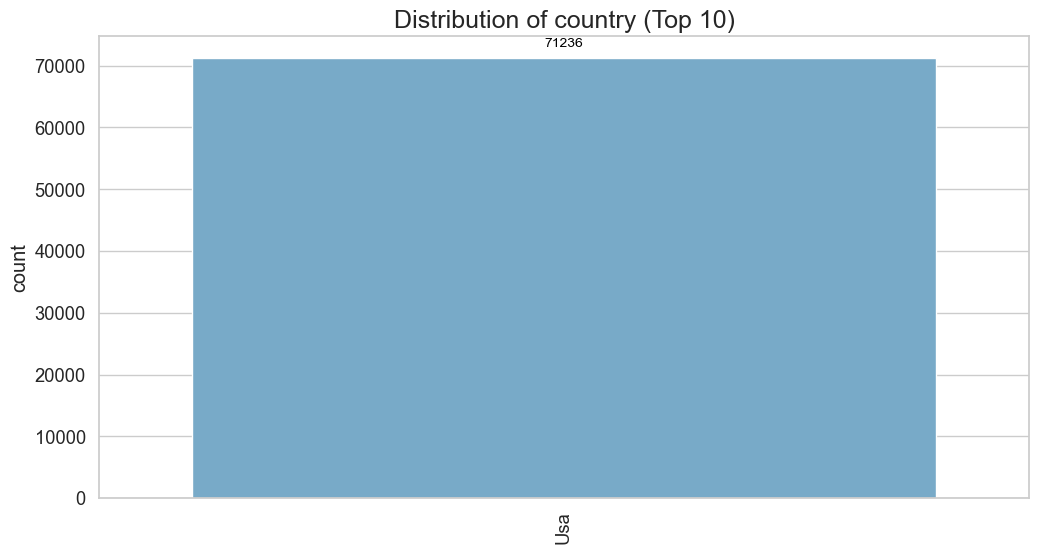

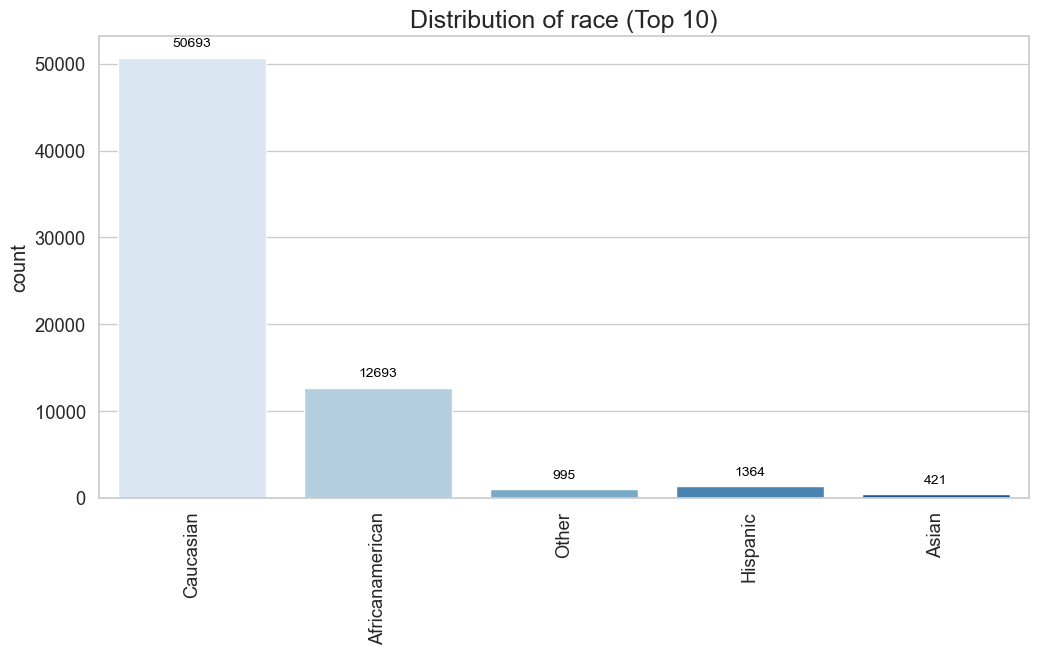

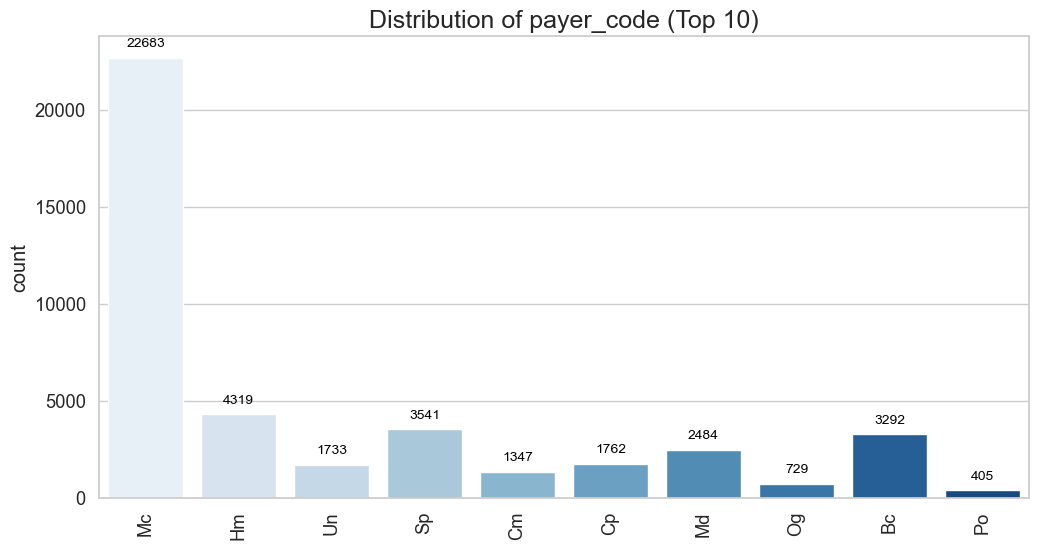

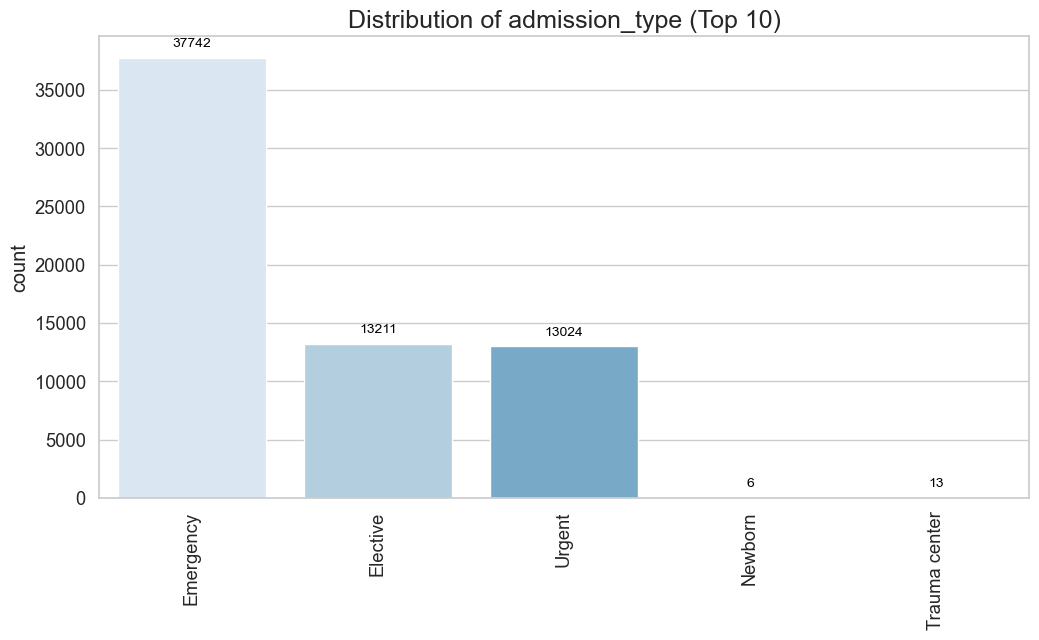

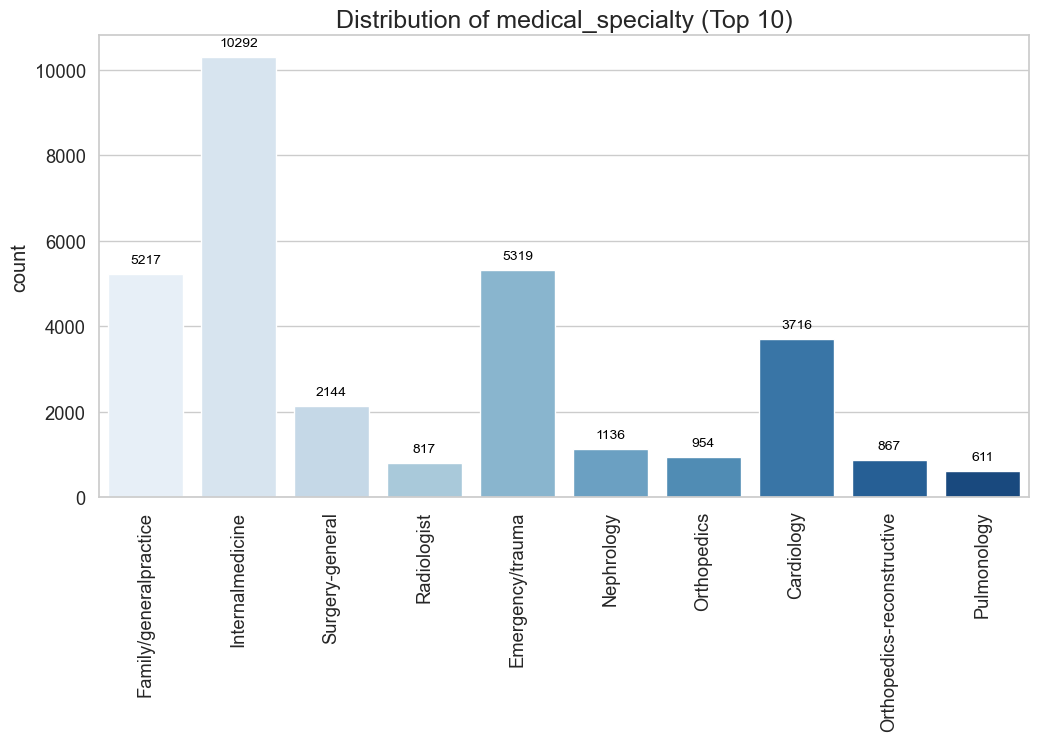

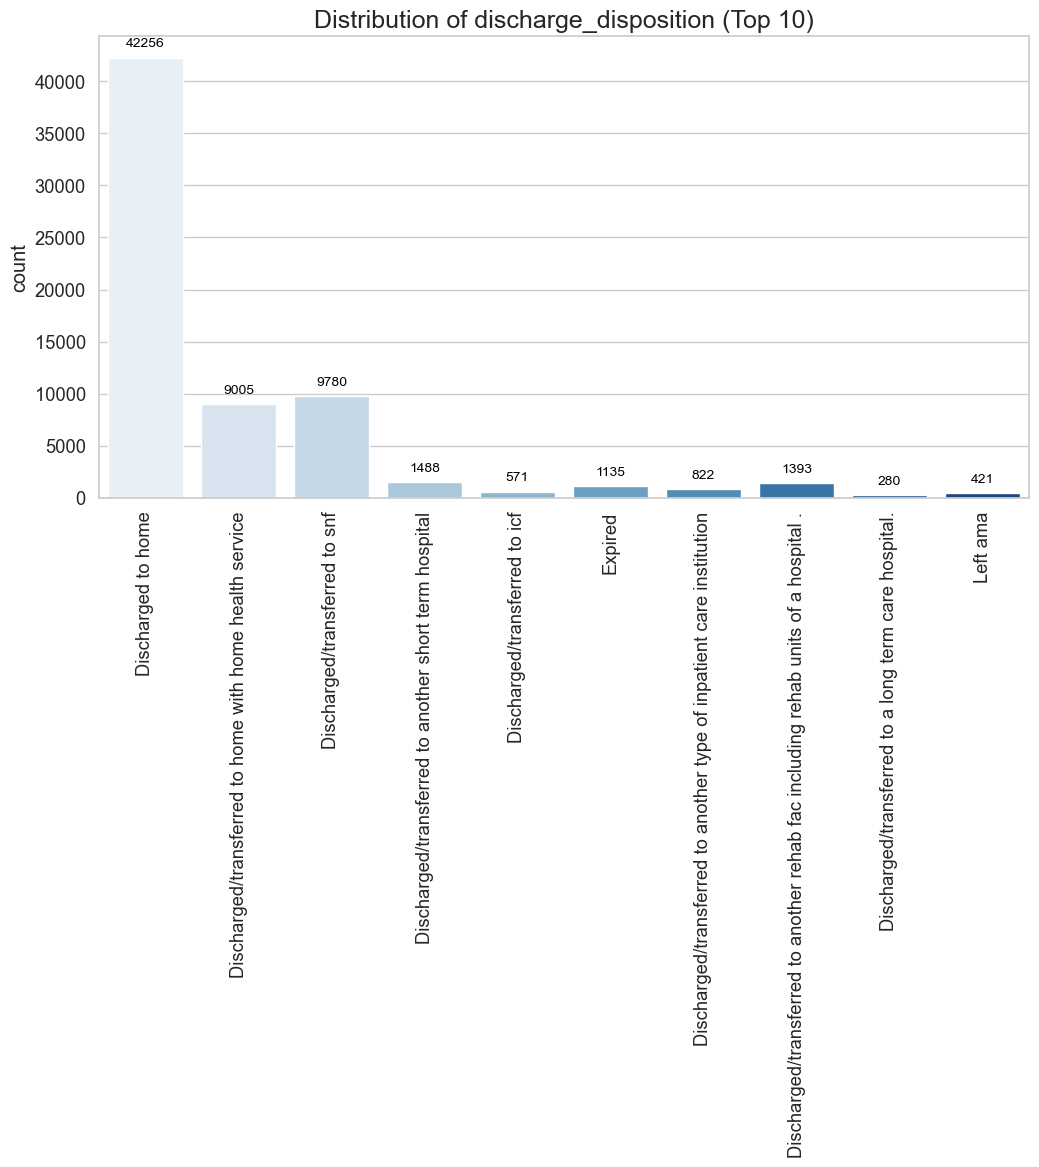

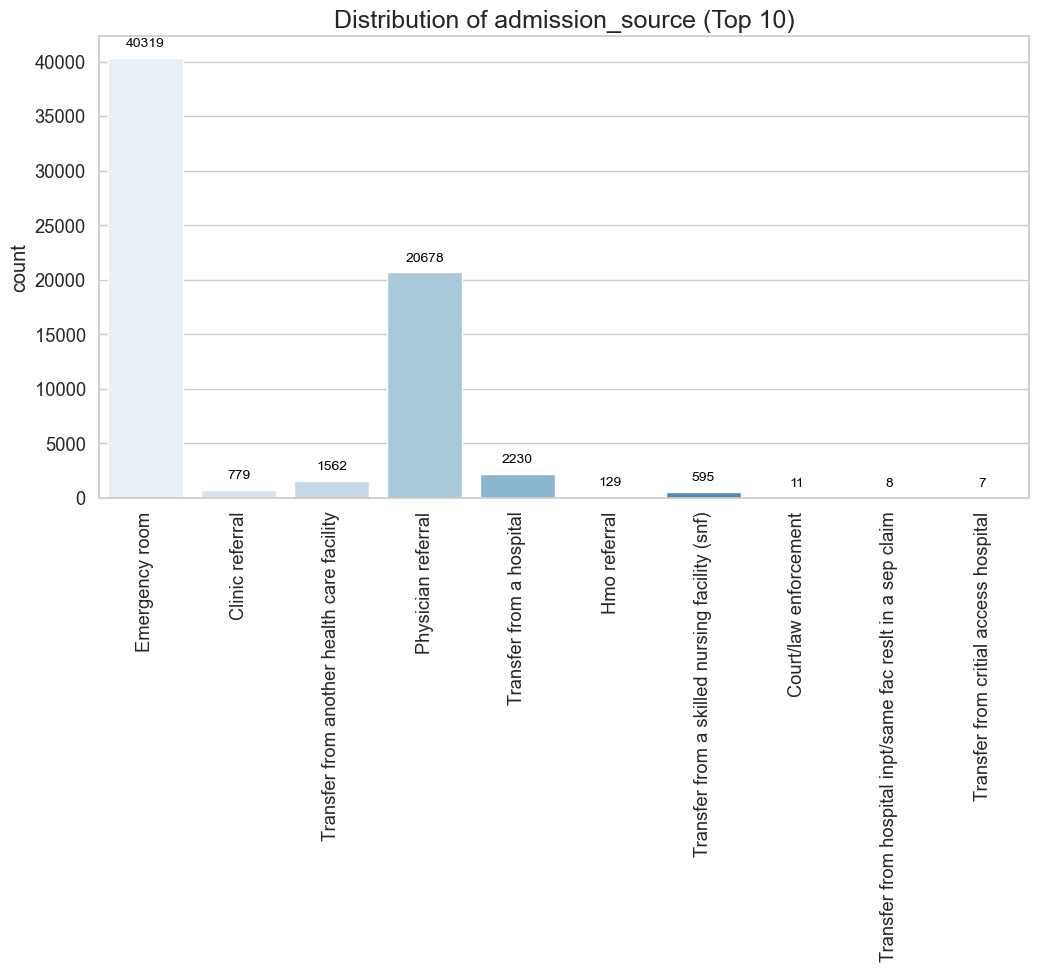

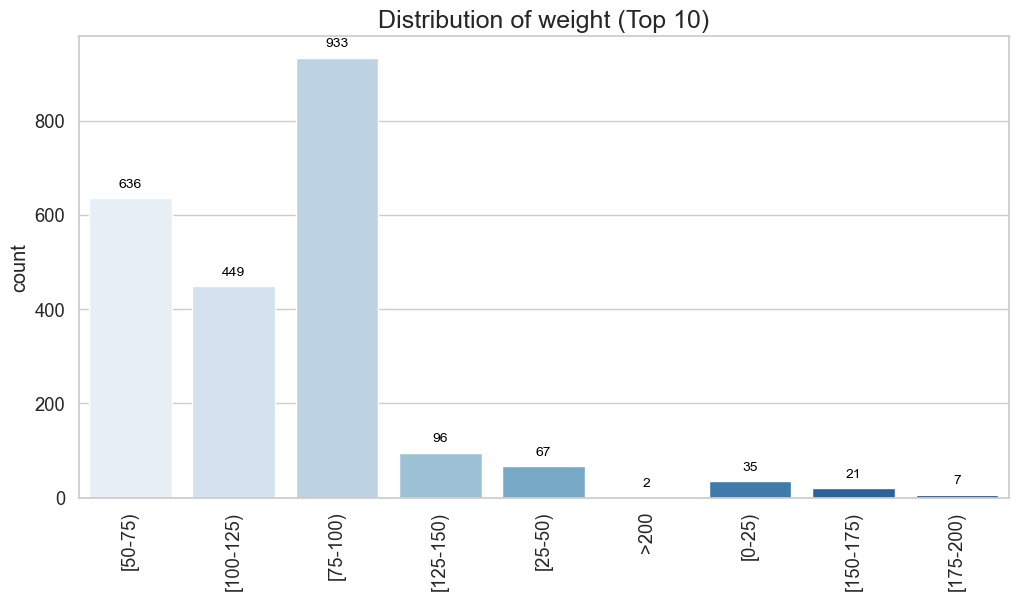

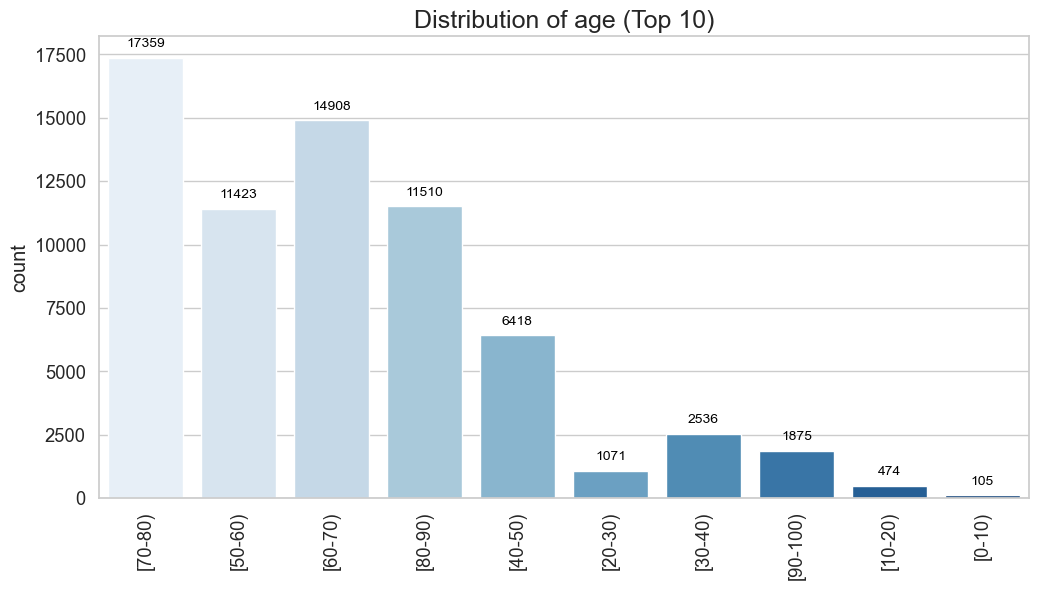

<Figure size 640x480 with 0 Axes>

In [33]:

sns.set(style="whitegrid", font_scale=1.2)

for column in lstvars_categorical:
    top_10_features = df_data_exploration[column].value_counts().nlargest(10).index
    
    # Filter the dataframe to include only the top 10 features
    filtered_data = df_data_exploration[df_data_exploration[column].isin(top_10_features)]
    
    plt.figure(figsize=(12, 6))
    chart = sns.countplot(data=filtered_data, x=column, palette='Blues')
    plt.title(f'Distribution of {column} (Top 10)', fontsize=18)
    plt.xlabel('')
    
    plt.xticks(rotation=90)
    
    for p in chart.patches:
        plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                     textcoords='offset points')
    
    plt.show()

plt.subplots_adjust(hspace=0.8)


#### 3.3.2 Multivariate Analysis

**Numerical Features vs Target**

>Box Plot


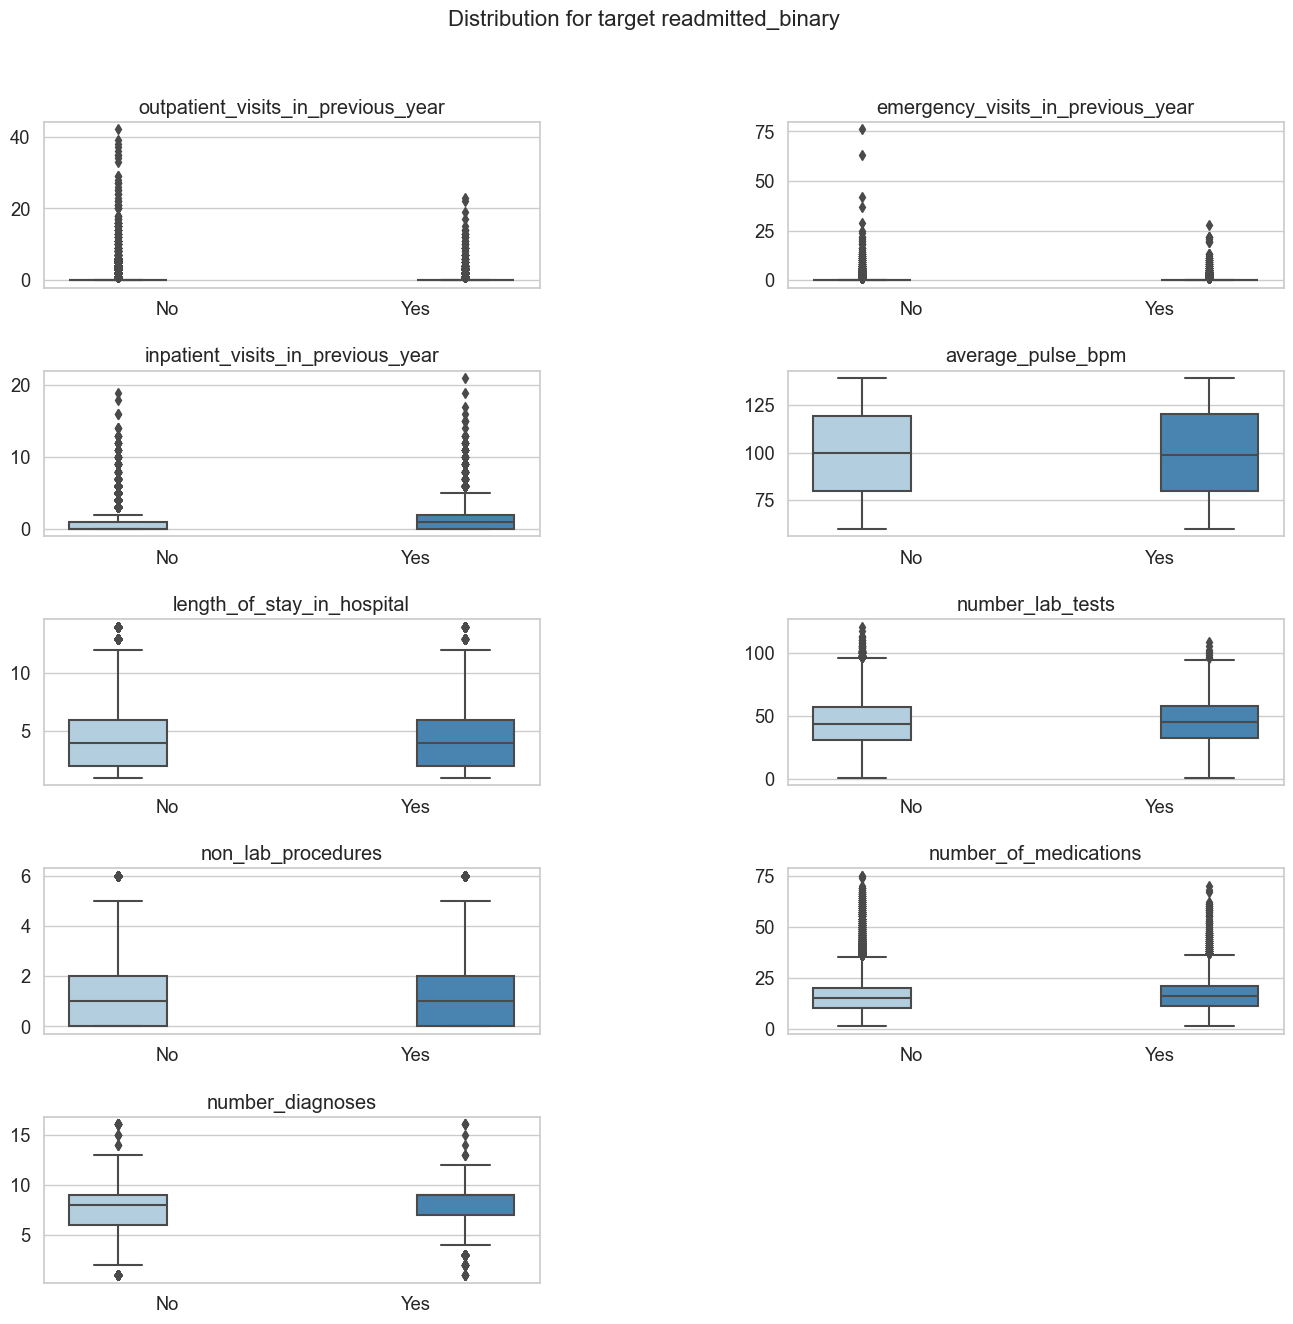

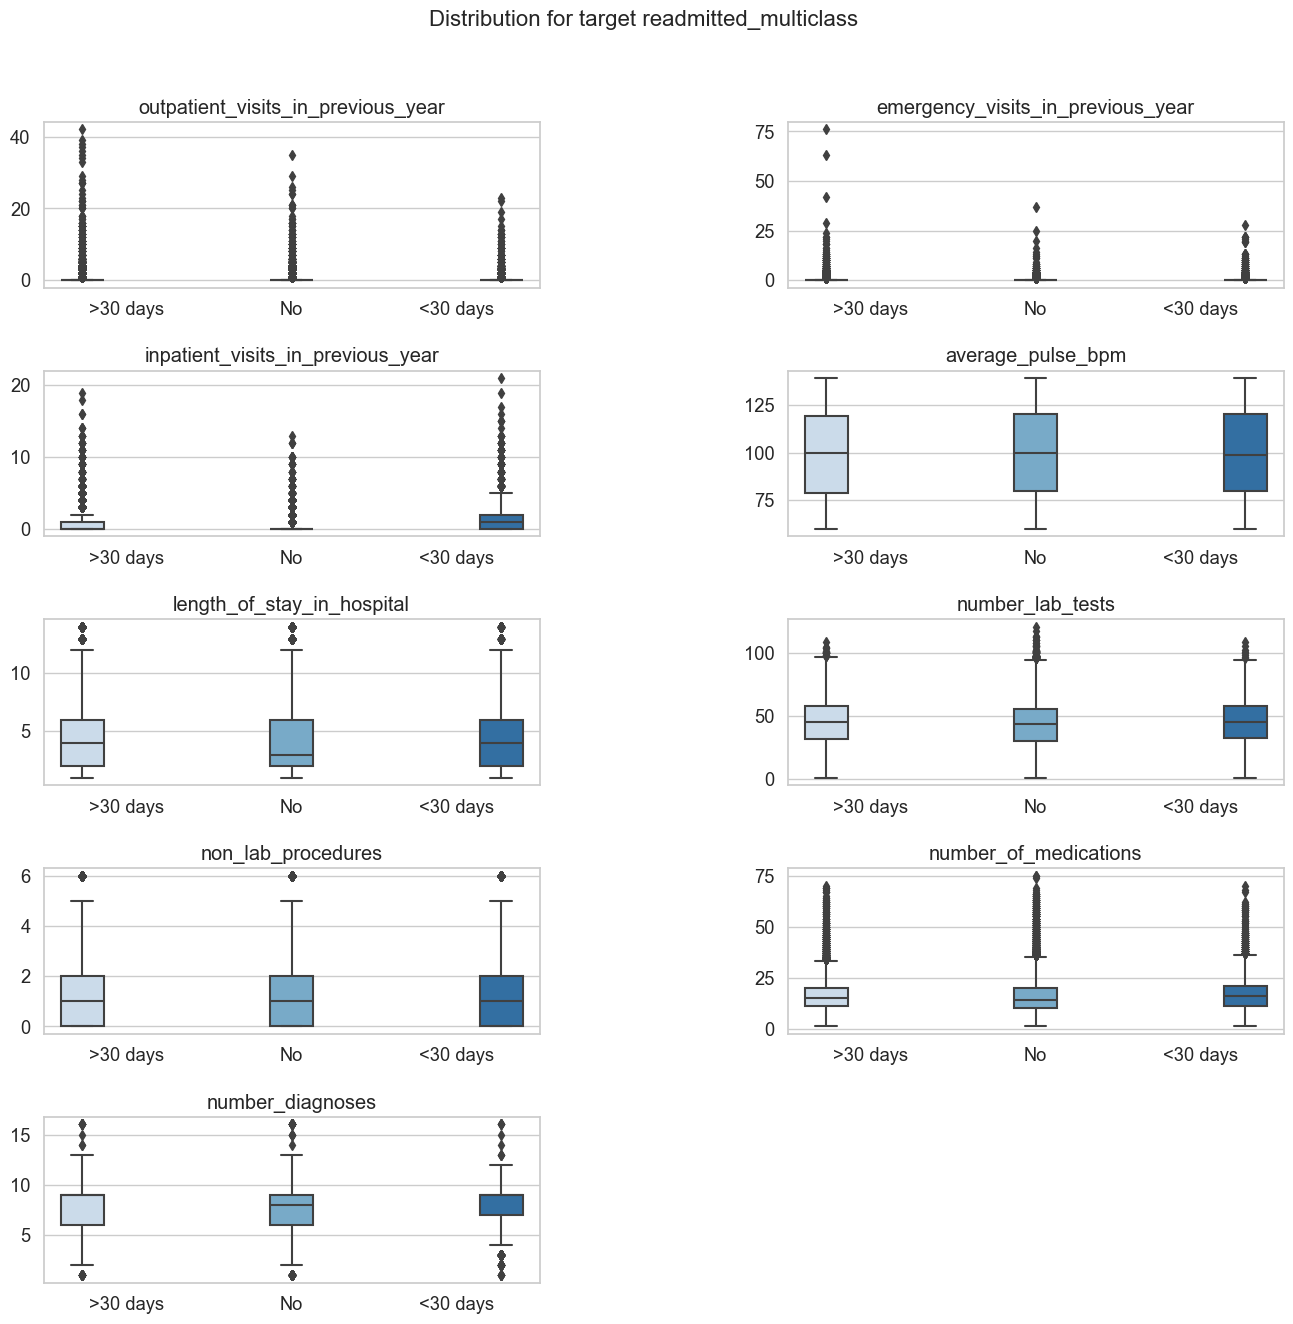

In [34]:
for target in lstvars_targets:
    fig = plt.figure(figsize=(16, 28))
    plt.suptitle("Distribution for target " + target, fontsize=16, y=0.92)

    for i in range(len(lstvars_numerical)):
        column = lstvars_numerical[i]
        sub = fig.add_subplot(len(lstvars_numerical), 2, i + 1)
        chart = sns.boxplot(data=df_data_exploration, x=target, y=column, palette='Blues', hue=target, ax=sub)
        sub.set_xlabel("")
        sub.set_ylabel("")
        sub.set_title(column)
        if chart.legend_ is not None:
            chart.legend_.remove()  # Remove the legend from each subplot if it exists

    plt.subplots_adjust(hspace=0.5, wspace=0.5)  
    plt.show()


>Target Features

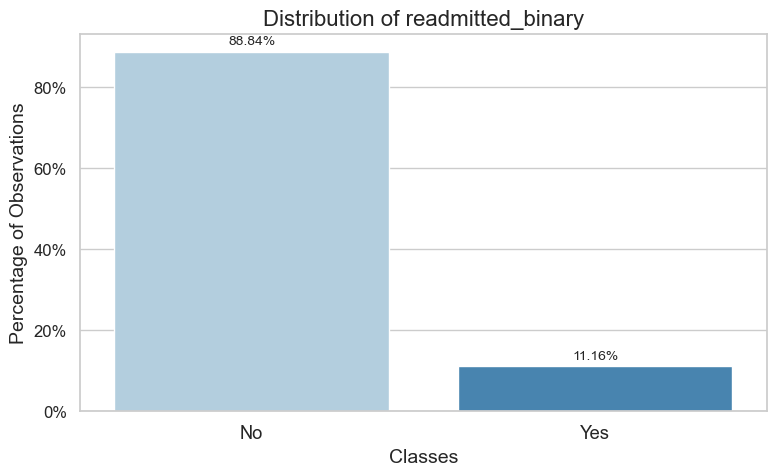

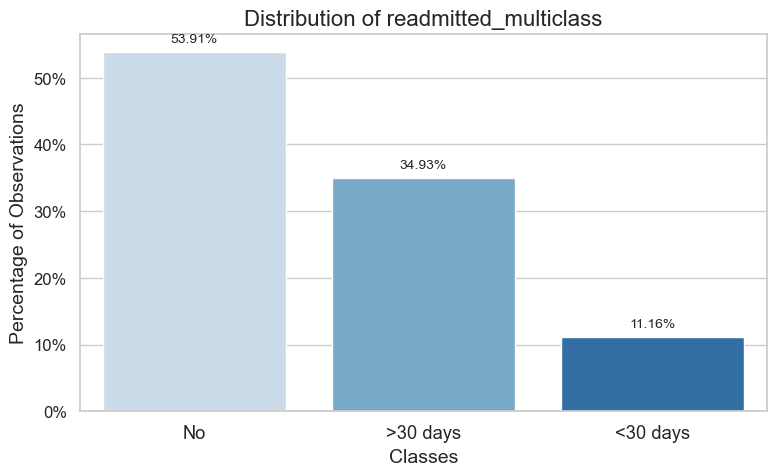

In [35]:
plot_class_percentages(df_data_exploration, 'readmitted_binary')
plot_class_percentages(df_data_exploration, 'readmitted_multiclass')


>Binary features vs target, Bar chart

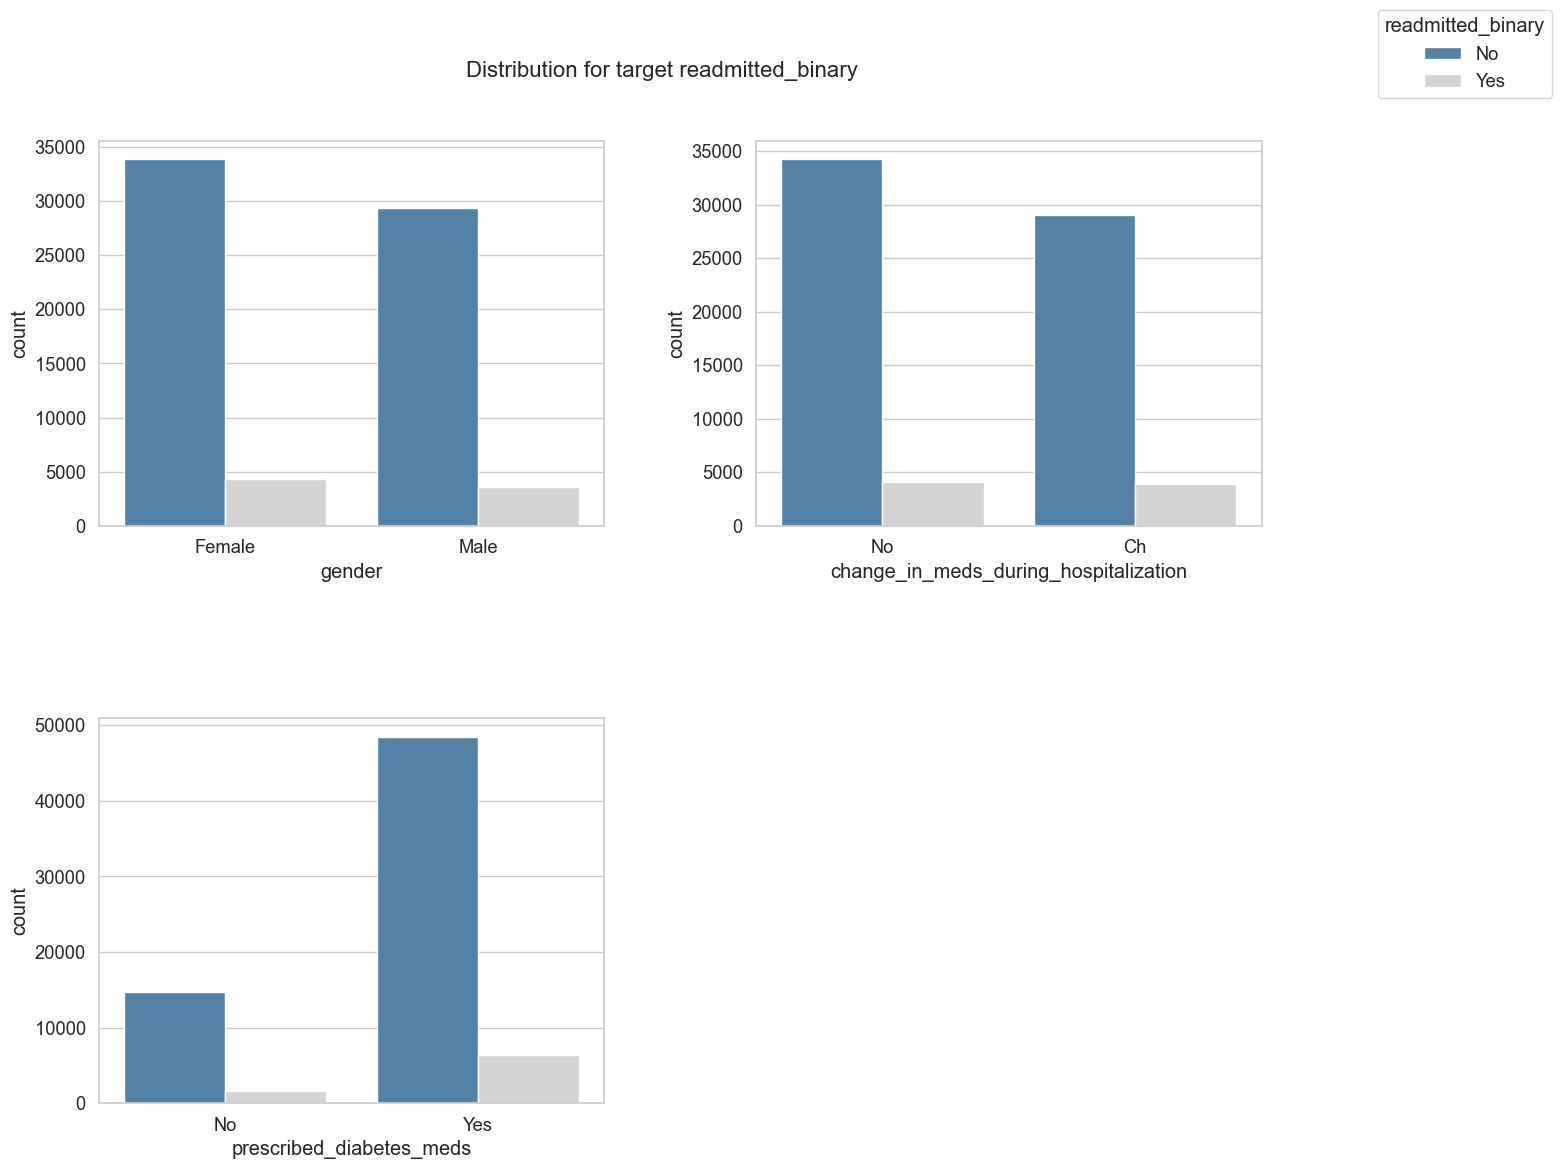

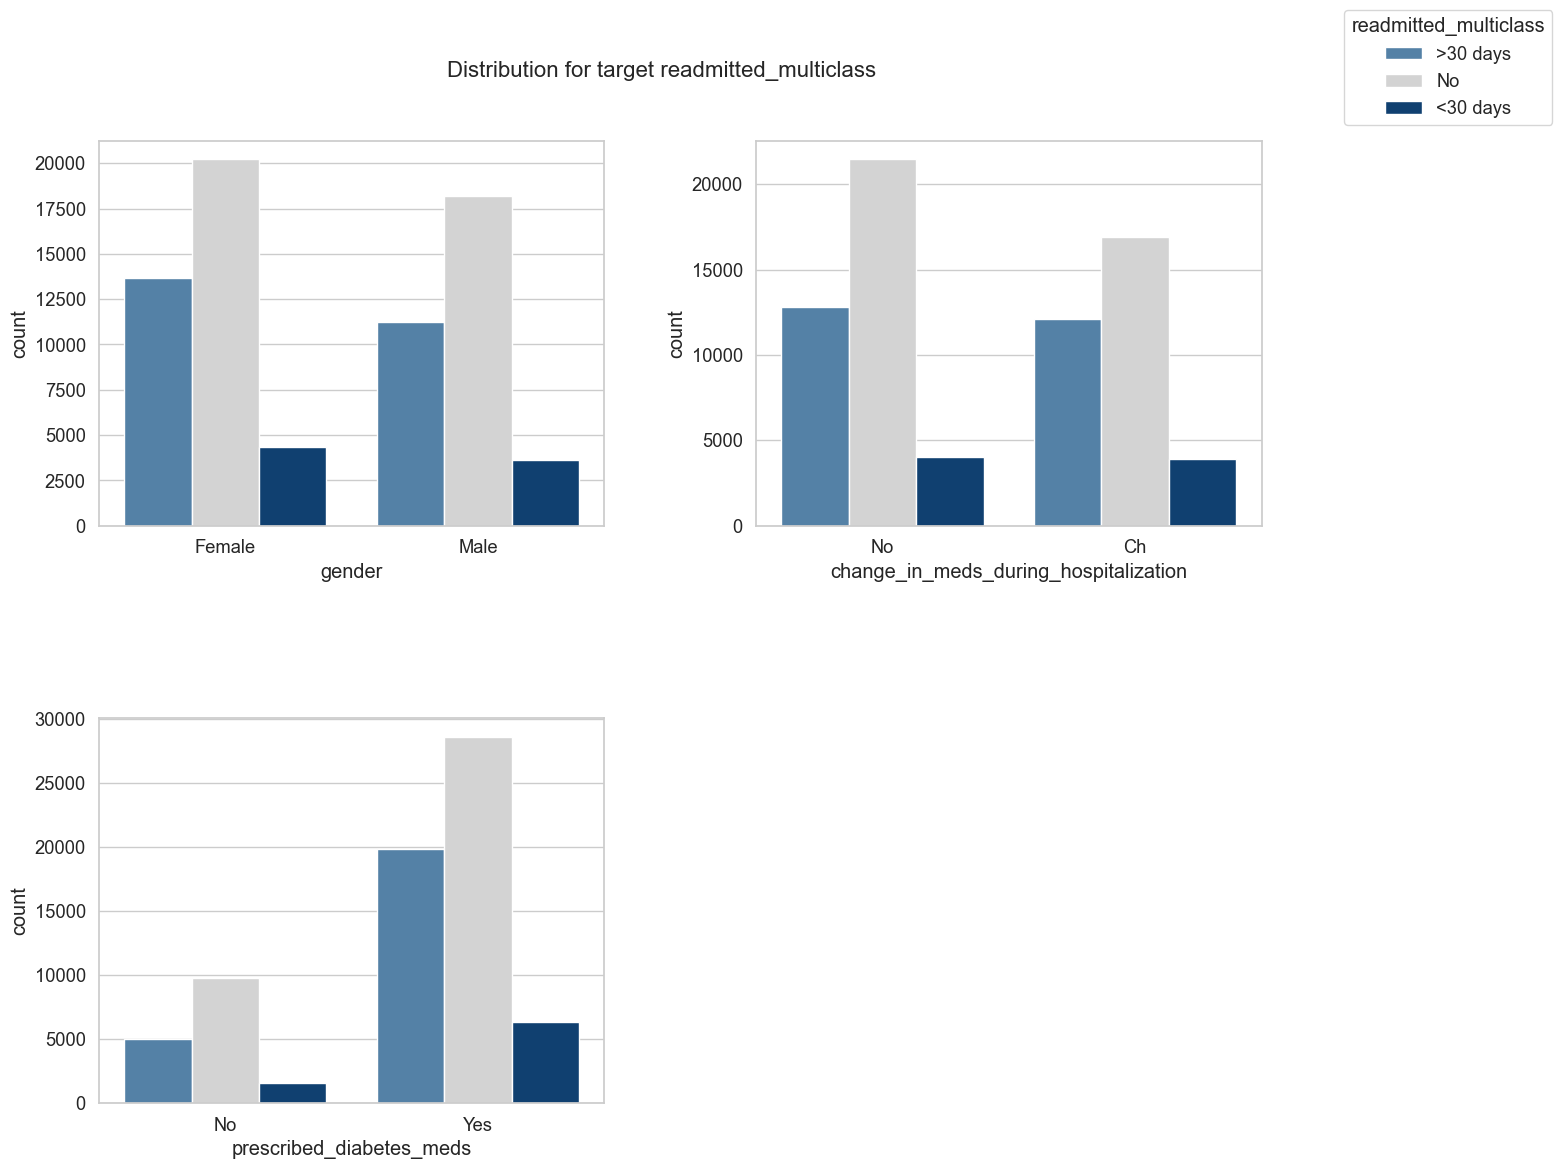

In [36]:

for target in lstvars_targets:
    fig = plt.figure(figsize=(15, 20))
    fig.suptitle("Distribution for target " + target, fontsize=16, y=0.92)


    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i in range(len(lstvars_binary_cat)):
        column = lstvars_binary_cat[i]
        sub = fig.add_subplot(len(lstvars_binary_cat), 2, i + 1)
        chart = sns.countplot(data=df_data_exploration, x=column, hue=target, palette=['#4682B4', '#D3D3D3', '#004080', '#1F497D'])

        
        chart.legend_.remove()
    
    handles, labels = sub.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title=target, bbox_to_anchor=(1.1, 0.95))

plt.show()


**Categorical Features vs Target**

>Grouped Bar Chart

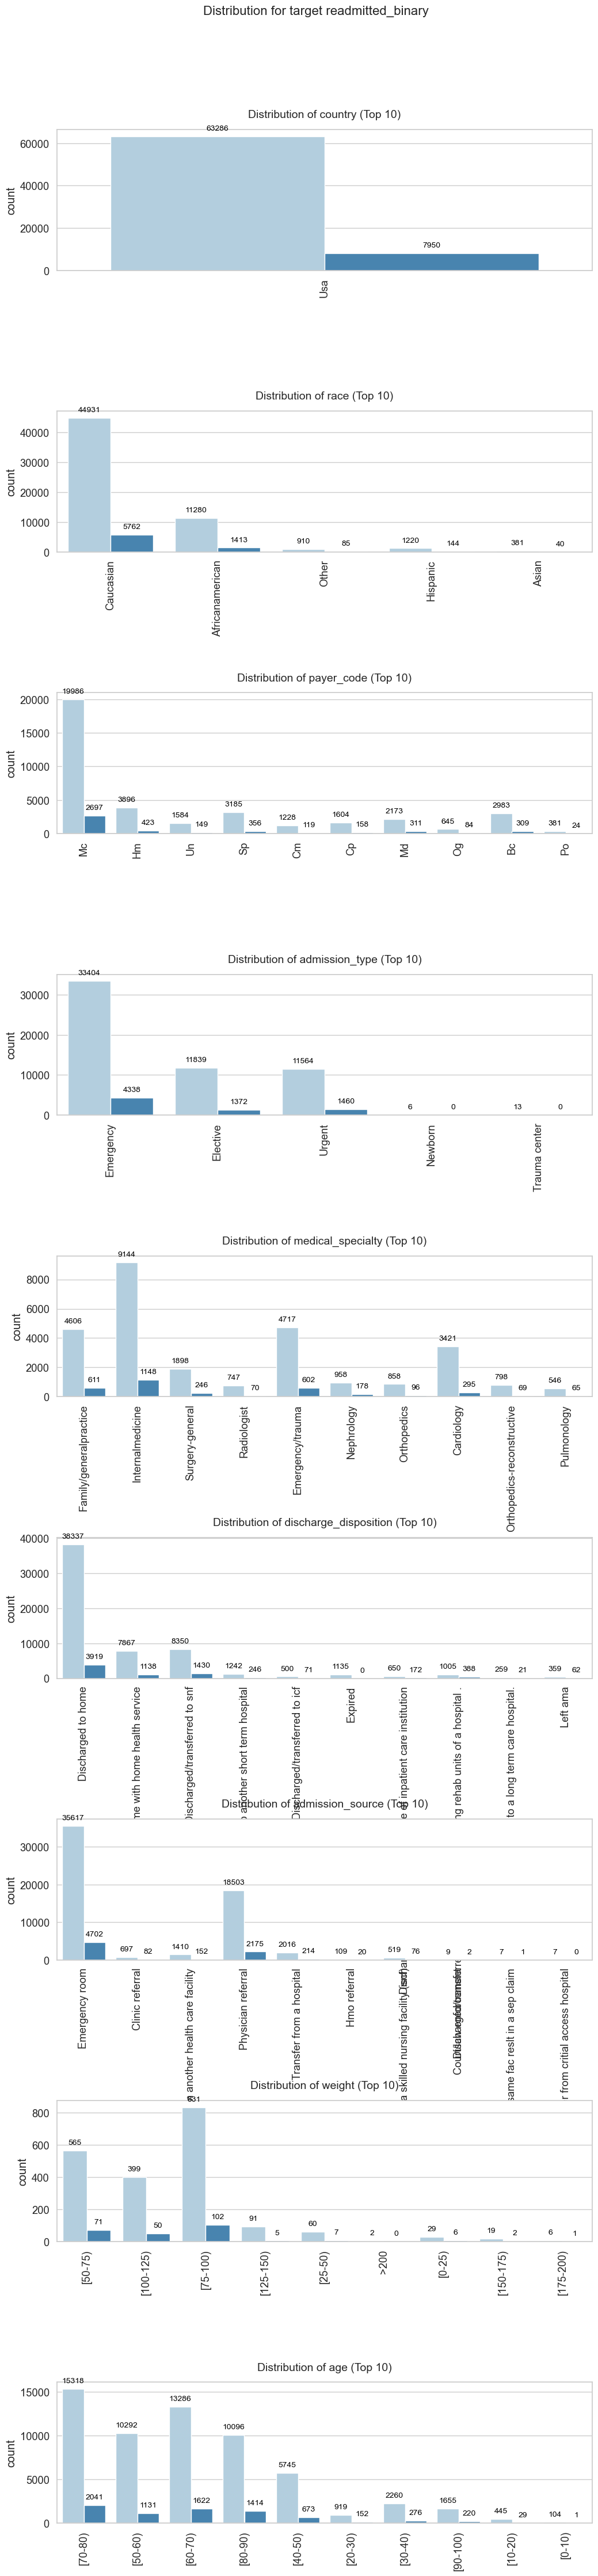

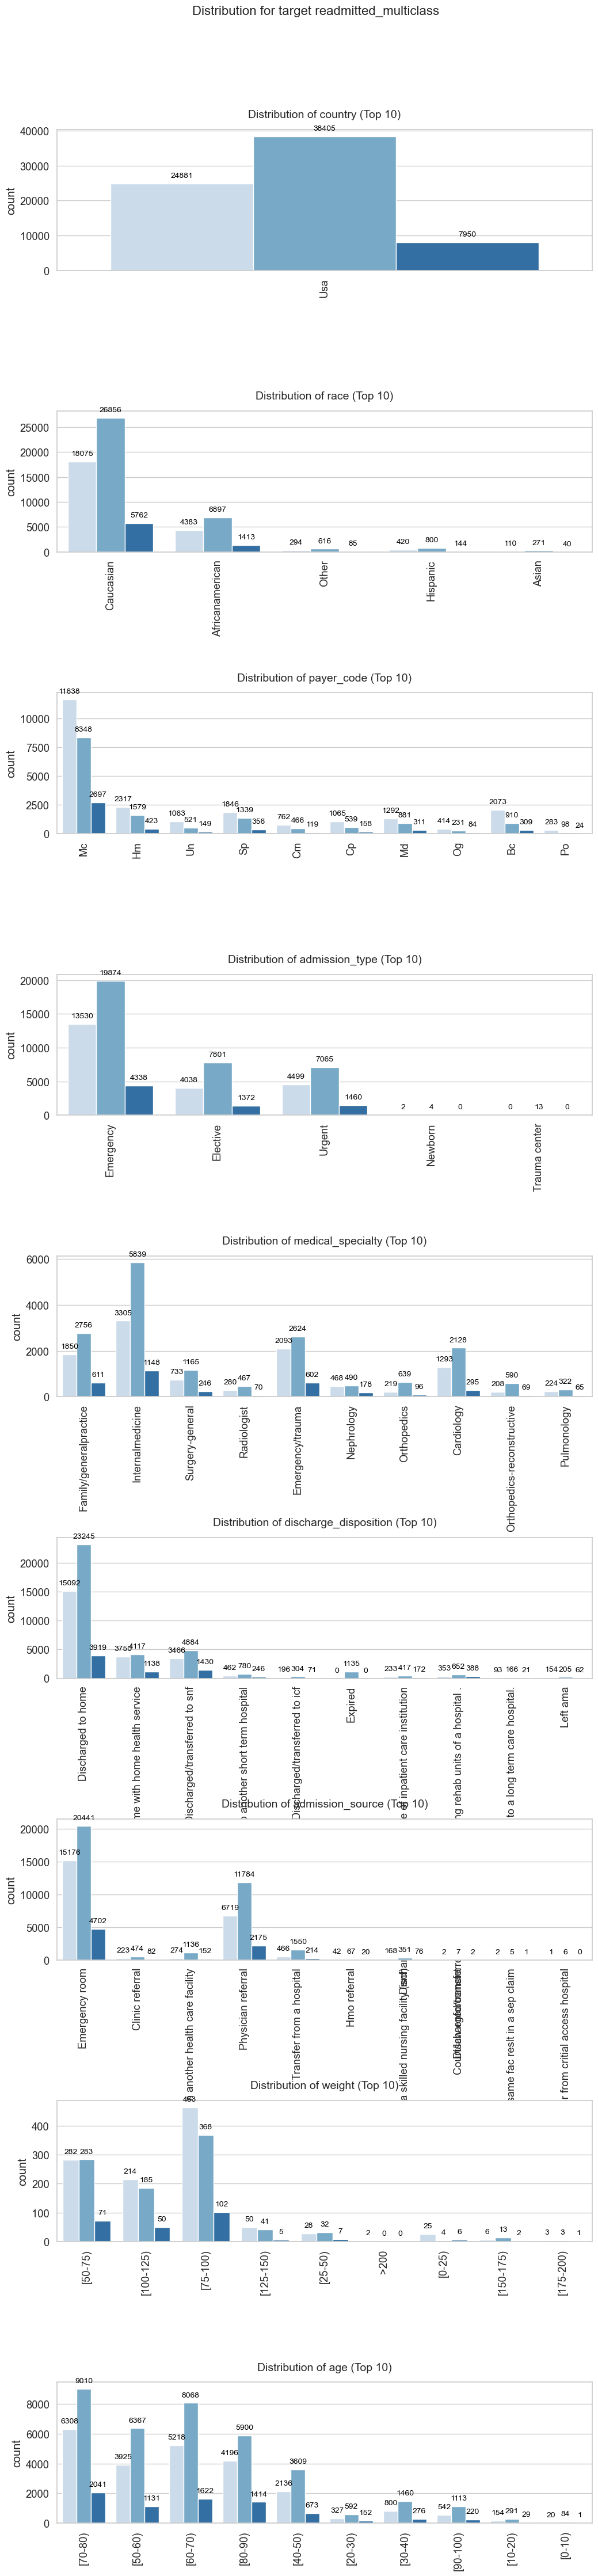

In [37]:
sns.set(style="whitegrid", font_scale=1.2)


for target in lstvars_targets:
    fig, axes = plt.subplots(len(lstvars_categorical), 1, figsize=(12, 6 * len(lstvars_categorical)))
    fig.suptitle("Distribution for target " + target, fontsize=16, y=0.92)

    for i, column in enumerate(lstvars_categorical):
        top_10_features = df_data_exploration[column].value_counts().nlargest(10).index

        
        filtered_data = df_data_exploration[df_data_exploration[column].isin(top_10_features)]

        ax = axes[i]
        chart = sns.countplot(data=filtered_data, x=column, hue=target, palette='Blues', ax=ax)
        ax.set_title(f'Distribution of {column} (Top 10)', fontsize=14, pad=15)
        ax.set_xlabel('')

        chart.legend_.remove()

        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        
        # Annotating the count on each bar as integers for better readability
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                        textcoords='offset points')

    plt.subplots_adjust(hspace=1)
    plt.show()


#### 3.4 Reset variable names in the lists of variables
Variable lists were defined for being used in the data exploration phase.<br>
Now I'm changing them to be used in the data engineering phase.


In [38]:
#Define the columns of each nature

lstvars_todrop = []

lstvars_non_ordinal_cat = ["country", "race", "payer_code", "admission_type", "specialty_mappings", "discharge_disposition", "admission_source"] 
lstvars_ordinal_cat     = ["patient_id", "weightgroup", 'agegroup']
lstvars_binary_cat      = ['isfemale', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds']    
lstvars_numerical       = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year',
       'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

lstvars_targets = [target_var_BC, target_var_MC]
lstvars_categorical = lstvars_non_ordinal_cat + lstvars_ordinal_cat



<a class="anchor" id="topic04" /> <br>
## Step 4 - Data Preprocessing
[Back to Index](#index)

#### 4.1 Feature Engineering

In [39]:
# The features have to be created for all the dataframes, so I create them by looping over the dataframes list.

dfs = [X_train_BC, X_val_BC, X_trainval_BC, X_test_BC, X_train_MC, X_val_MC, X_trainval_MC, X_test_MC]

for df in dfs:
    df["synt_medicine_insulin"] = df["medication"].str.contains("insulin").astype(int)
    df["synt_medicine_number_of_meds"] = df["medication"].apply(lambda x: 0 if x == '[]' else len(str(x).split()))
    df["synt_number_oral_hypoglycemic_meds"] = df["synt_medicine_number_of_meds"] - df["synt_medicine_insulin"]

    df[["synt_pri_diag_letter", "synt_pri_diag_code", "synt_pri_diag_subcode"]] = df["primary_diagnosis"].str.extract("^([A-Za-z]?)(\d+)?\.?(\d+)?$")
    df[["synt_sec_diag_letter", "synt_sec_diag_code", "synt_sec_diag_subcode"]] = df["secondary_diagnosis"].str.extract("^([A-Za-z]?)(\d+)?\.?(\d+)?$")
    df[["synt_add_diag_letter", "synt_add_diag_code", "synt_add_diag_subcode"]] = df["additional_diagnosis"].str.extract("^([A-Za-z]?)(\d+)?\.?(\d+)?$")

    df["tested_for_glucose"] = [0 if pd.isna(x) else 1 for x in df["glucose_test_result"]]
    df["tested_for_a1c"] = [0 if pd.isna(x) else 1 for x in df["a1c_test_result"]]
    
    df['same_patient'] = df.duplicated(subset='patient_id', keep=False).astype(int)
    
lstvars_binary_cat.extend(["synt_medicine_insulin", "tested_for_glucose", "tested_for_a1c", "same_patient"])
lstvars_non_ordinal_cat.extend(["synt_pri_diag_letter", "synt_pri_diag_code", "synt_pri_diag_subcode", "synt_sec_diag_letter", "synt_sec_diag_code", "synt_sec_diag_subcode", "synt_add_diag_letter", "synt_add_diag_code", "synt_add_diag_subcode"])
lstvars_categorical = lstvars_non_ordinal_cat + lstvars_ordinal_cat
lstvars_numerical.extend(["synt_medicine_number_of_meds", "synt_number_oral_hypoglycemic_meds"])


#### 4.2 Handling Outliers

**First approach:** Removing outliers from all numerical features
<br>
I use the IQR criteria to define outliers; an outlier will be a value above Q75 + k * IQR or below Q25 - k * IQR
k is defined as a dictionary entry; I'm initilizing it as 3.


Binary Classification

In [40]:
q25 = X_train_BC[lstvars_numerical].quantile(.25)
q75 = X_train_BC[lstvars_numerical].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + dicParams["outlier_threshold_IQR_upper"] * iqr
lower_lim = q25 - dicParams["outlier_threshold_IQR_lower"] * iqr

for metric in lstvars_numerical:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    set_interval_feature_val( list_dataframes=[X_train_BC, X_val_BC, X_trainval_BC, X_test_BC], feature=metric, maxlimit=ulim, minlimit = llim, verbose=False)



Multiclass classification

In [41]:
q25 = X_train_MC[lstvars_numerical].quantile(.25)
q75 = X_train_MC[lstvars_numerical].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + dicParams["outlier_threshold_IQR_upper"] * iqr
lower_lim = q25 - dicParams["outlier_threshold_IQR_lower"] * iqr

for metric in lstvars_numerical:
    set_interval_feature_val( list_dataframes=[X_train_MC, X_val_MC, X_trainval_MC, X_test_MC], feature=metric, maxlimit=upper_lim[metric], minlimit = lower_lim[metric], verbose=False)


#### 4.3  Feature Selection - Binary Classification (3 steps)

Applying the statistical tests, wrapper, ....

In [42]:
lstvars_todrop_BC = []
lstvars_todrop_MC = []


lstvars_numerical_BC       = [x for x in lstvars_numerical if x not in lstvars_todrop_BC]
lstvars_non_ordinal_cat_BC = [x for x in lstvars_non_ordinal_cat if x not in lstvars_todrop_BC]
lstvars_ordinal_cat_BC     = [x for x in lstvars_ordinal_cat     if x not in lstvars_todrop_BC]
lstvars_binary_cat_BC      = [x for x in lstvars_binary_cat      if x not in lstvars_todrop_BC]
lstvars_categorical_BC     = lstvars_non_ordinal_cat_BC + lstvars_ordinal_cat_BC
lstvars_categorical_all_BC   = lstvars_non_ordinal_cat_BC + lstvars_ordinal_cat_BC + lstvars_binary_cat_BC 

lstvars_numerical_MC       = [x for x in lstvars_numerical if x not in lstvars_todrop_MC]
lstvars_non_ordinal_cat_MC = [x for x in lstvars_non_ordinal_cat if x not in lstvars_todrop_MC]
lstvars_ordinal_cat_MC     = [x for x in lstvars_ordinal_cat     if x not in lstvars_todrop_MC]
lstvars_binary_cat_MC      = [x for x in lstvars_binary_cat      if x not in lstvars_todrop_MC]
lstvars_categorical_MC     = lstvars_non_ordinal_cat_MC + lstvars_ordinal_cat_MC
lstvars_categorical_all_MC     = lstvars_non_ordinal_cat_MC + lstvars_ordinal_cat_MC + lstvars_binary_cat_MC 


In [43]:
#Get categorical data + target variable
X_train_cat_BC = X_train_BC[lstvars_categorical_all_BC]
X_train_cat_BC[target_var_BC] = y_train_BC

X_train_num_BC = X_train_BC[lstvars_numerical]
X_val_num_BC = X_val_BC[lstvars_numerical]



<li> <b> 1st Step: Doing the tests applied only to the categorical data:</b> Chi-Square and % of values missing</li>

#### Chi-square

Evaluate feature relevance for the binary target and determine list of variables that are not important.

In [44]:
# Print feature relevance, binary target
print("Feature relevance, binary target")

lstvars_todrop_BC_chisqr = get_independent_cats_chi2(X_train_cat_BC, target_var_BC, alpha=dicParams["threshold_chi2_alpha"])

for var in lstvars_todrop_BC_chisqr:
    lstvars_todrop_BC.append(var)

Feature relevance, binary target
country is NOT an important predictor. (Discard country from model)
race is NOT an important predictor. (Discard race from model)
payer_code is IMPORTANT for Prediction
admission_type is NOT an important predictor. (Discard admission_type from model)
specialty_mappings is IMPORTANT for Prediction
discharge_disposition is IMPORTANT for Prediction
admission_source is NOT an important predictor. (Discard admission_source from model)
synt_pri_diag_letter is IMPORTANT for Prediction
synt_pri_diag_code is IMPORTANT for Prediction
synt_pri_diag_subcode is IMPORTANT for Prediction
synt_sec_diag_letter is IMPORTANT for Prediction
synt_sec_diag_code is IMPORTANT for Prediction
synt_sec_diag_subcode is IMPORTANT for Prediction
synt_add_diag_letter is NOT an important predictor. (Discard synt_add_diag_letter from model)
synt_add_diag_code is IMPORTANT for Prediction
synt_add_diag_subcode is NOT an important predictor. (Discard synt_add_diag_subcode from model)
pati

Check for features with high % missing: 

In [45]:
high_missing_cols = []


for column in X_train_cat_BC:
    
    if ((X_train_cat_BC[column].isna().mean()) *100) > 40:

        high_missing_cols.append(column) 
    
        lstvars_todrop_BC.append(column)

print(f"Columns with more thant 40% of missing data: {high_missing_cols}")


Columns with more thant 40% of missing data: ['specialty_mappings', 'synt_pri_diag_subcode', 'synt_sec_diag_subcode', 'synt_add_diag_subcode', 'weightgroup']


<li> <b> 2nd Step: Doing the tests applied only to the numerical data:</b> Multicollinearity, Lasso Regression, RFE and Mutual Information</li>

__Multicollinearity__

Multicollinearity arises when there is a correlation between any two features. In machine learning, it is expected that each feature should be independent of others, i.e., there’s no colinearity between them.
In that sense, I want to remove features that are highly correlated with other explanatory variables.

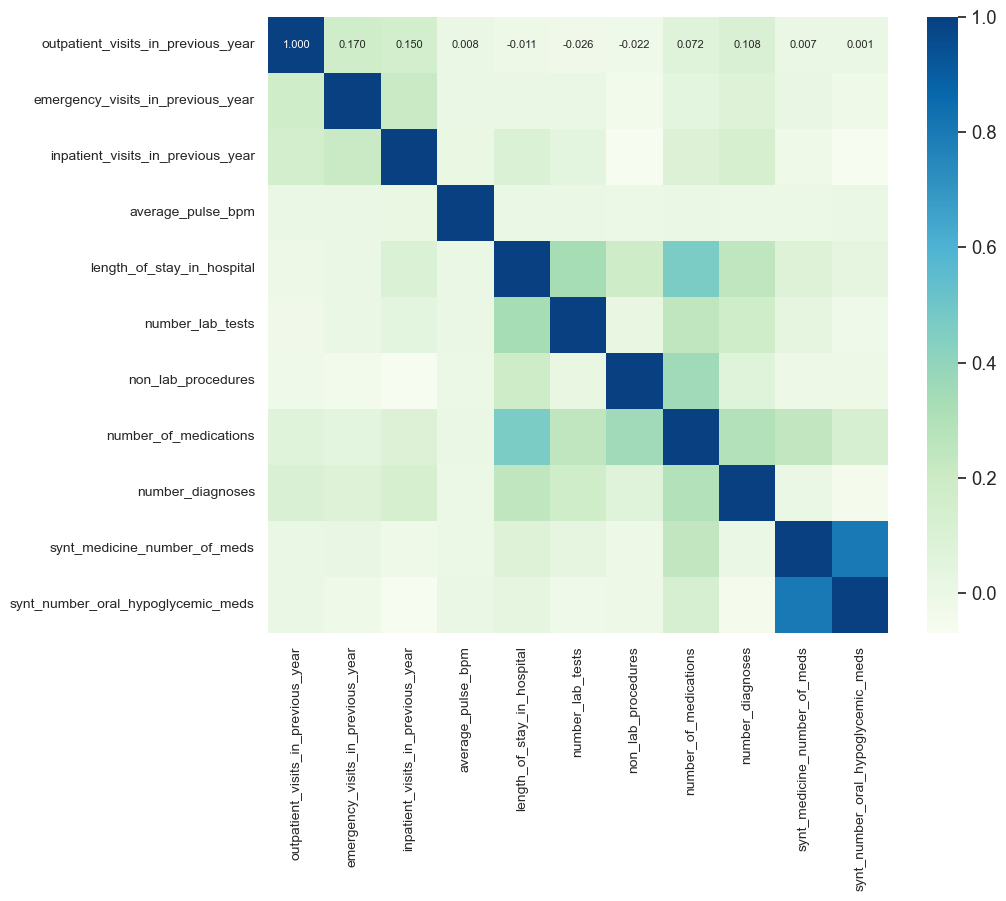

In [46]:
correlation_BC = X_train_num_BC.corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_BC, cmap='GnBu', annot=True, fmt=".3f", annot_kws={"size": 8},
            xticklabels=correlation_BC.columns, yticklabels=correlation_BC.columns)

# Adjust the font size of the labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

NOTES:<br>
<br>
<li>synt_medicine_number_of_meds and synt_number_oral_hypoglycemic_meds have a high correlation 0.801. I remove the first one because has higher correlation with features<br>
<br>
<li>Also number_of_medications and length_of_stay_in_hospital show a relevant correlation of 0.462.<br>
<br>
<li>average_pulse_bpm has almost not correlation with other features<br>
<br>




In [47]:
for i in ["synt_medicine_number_of_meds", "number_of_medications"]:
    lstvars_todrop_BC.append(i)


In [48]:
scaler_BC = MinMaxScaler()

X_train_num_BC_scaled = scaler_BC.fit_transform(X_train_num_BC)
X_val_num_BC_scaled = scaler_BC.transform(X_val_num_BC) 

In [49]:
X_val_num_BC_scaled = pd.DataFrame(X_val_num_BC_scaled, columns = X_val_num_BC.columns).set_index(X_val_BC.index)
X_train_num_BC_scaled = pd.DataFrame(X_train_num_BC_scaled, columns = X_train_num_BC.columns).set_index(X_train_BC.index)

#### Lasso Regression

I check the coefficients of the regression to see if some features are being negleted for the evaluation of the output.

Lasso Regression, Binary Target

In [50]:
reg = LassoCV()


In [51]:
y_train_BC_bin = [1 if x =="Yes" else 0 for x in y_train_BC]

reg.fit(X_train_num_BC_scaled, y_train_BC_bin)

LassoCV()

In [52]:
coef = pd.Series(reg.coef_, index = X_train_num_BC.columns)
coef

outpatient_visits_in_previous_year    0.001947
emergency_visits_in_previous_year     0.022161
inpatient_visits_in_previous_year     0.165593
average_pulse_bpm                     0.000000
length_of_stay_in_hospital            0.016744
number_lab_tests                     -0.000964
non_lab_procedures                   -0.009964
number_of_medications                 0.025189
number_diagnoses                      0.062261
synt_medicine_number_of_meds          0.051118
synt_number_oral_hypoglycemic_meds   -0.048518
dtype: float64

In [53]:
for a in coef.index:
    if abs(coef[a]) < 0.00005 :
        print(f"Lasso with a treshold of 0.0005 eliminates features '{a}'")
        lstvars_todrop_BC.append(a)


Lasso with a treshold of 0.0005 eliminates features 'average_pulse_bpm'


__RFE__

RFE, Binary Target

In [54]:

#no of features
nof_list=np.arange(1, 10)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    
    X_train_rfe = rfe.fit_transform(X_train_num_BC_scaled,y_train_BC)
    X_val_rfe = rfe.transform(X_val_num_BC_scaled)
    
    model.fit(X_train_rfe,y_train_BC)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train_BC)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val_BC)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
        
        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_num_BC.columns)
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 9
Score with 9 features: 0.885507
Features to select: 
outpatient_visits_in_previous_year    False
emergency_visits_in_previous_year      True
inpatient_visits_in_previous_year      True
average_pulse_bpm                     False
length_of_stay_in_hospital             True
number_lab_tests                       True
non_lab_procedures                     True
number_of_medications                  True
number_diagnoses                       True
synt_medicine_number_of_meds           True
synt_number_oral_hypoglycemic_meds     True
dtype: bool


In [55]:
for a in features_to_select.index:
    
    if features_to_select[a] == False:
        
        lstvars_todrop_BC.append(a)

### Mutual Information 

A non-negative value that measures the mutual dependence between two random discrete variables

Mutual Information, Binary Target

In [56]:
mutual_info = mutual_info_classif(X_train_num_BC, y_train_BC)

In [57]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_num_BC.columns
mutual_info.sort_values(ascending=False)

inpatient_visits_in_previous_year     0.008125
synt_medicine_number_of_meds          0.006556
number_of_medications                 0.004113
number_diagnoses                      0.003923
emergency_visits_in_previous_year     0.003096
synt_number_oral_hypoglycemic_meds    0.002425
length_of_stay_in_hospital            0.002339
non_lab_procedures                    0.001636
number_lab_tests                      0.000729
outpatient_visits_in_previous_year    0.000000
average_pulse_bpm                     0.000000
dtype: float64

In [58]:
for a in mutual_info.index:
    if abs(mutual_info[a]) < 0.00005 :
        print(f"Mutual Information with a treshold of 0.0005 discarcs '{a}'")
        lstvars_todrop_BC.append(a)

Mutual Information with a treshold of 0.0005 discarcs 'outpatient_visits_in_previous_year'
Mutual Information with a treshold of 0.0005 discarcs 'average_pulse_bpm'


<li> <b> 3rd Step: Removing the features based on the tests </li>

In [59]:
filter_values(lstvars_todrop_BC, X_train_cat_BC, X_train_num_BC)


['country',
 'race',
 'admission_type',
 'admission_source',
 'synt_add_diag_letter',
 'synt_add_diag_subcode',
 'patient_id',
 'weightgroup',
 'isfemale',
 'specialty_mappings',
 'synt_pri_diag_subcode',
 'synt_sec_diag_subcode',
 'average_pulse_bpm',
 'outpatient_visits_in_previous_year']

In [60]:
remove_features_BC()

### 4.4 Feature Selection - Multiclass Classification 

Applying the statistical tests, wrapper, ....

In [61]:
#Get categorical data + target variable
X_train_cat_MC = X_train_MC[lstvars_categorical_all_MC]
X_train_cat_MC[target_var_MC] = y_train_MC

X_train_num_MC = X_train_MC[lstvars_numerical]
X_val_num_MC = X_val_MC[lstvars_numerical]

In [62]:
lstvars_todrop_MC = []

<li> <b> 1st Step: Doing the tests applied only to the categorical data:</b> Chi-Square and % of missing values</li>

#### Chi-square

Evaluate feature relevance for the multiclass target and determine list of variables that are not important.

In [63]:
# Print feature relevance, binary target
print("Feature relevance, binary target")

lstvars_todrop_MC_chisqr = get_independent_cats_chi2(X_train_cat_MC, target_var_MC, alpha=dicParams["threshold_chi2_alpha"])

for var in lstvars_todrop_MC_chisqr:
    lstvars_todrop_MC.append(var)

Feature relevance, binary target
country is NOT an important predictor. (Discard country from model)
race is IMPORTANT for Prediction
payer_code is IMPORTANT for Prediction
admission_type is IMPORTANT for Prediction
specialty_mappings is IMPORTANT for Prediction
discharge_disposition is IMPORTANT for Prediction
admission_source is IMPORTANT for Prediction
synt_pri_diag_letter is IMPORTANT for Prediction
synt_pri_diag_code is IMPORTANT for Prediction
synt_pri_diag_subcode is IMPORTANT for Prediction
synt_sec_diag_letter is NOT an important predictor. (Discard synt_sec_diag_letter from model)
synt_sec_diag_code is IMPORTANT for Prediction
synt_sec_diag_subcode is IMPORTANT for Prediction
synt_add_diag_letter is NOT an important predictor. (Discard synt_add_diag_letter from model)
synt_add_diag_code is IMPORTANT for Prediction
synt_add_diag_subcode is IMPORTANT for Prediction
patient_id is NOT an important predictor. (Discard patient_id from model)
weightgroup is NOT an important predicto

Check for features with high % missing: 

In [64]:
high_missing_cols = []

for column in X_train_cat_MC:
#for column in X_train_MC[lstvars_categorical]:
    
    if ((X_train_cat_MC[column].isna().mean()) *100) > 40: #update dicParams["threshold_pct_on_nulls"] 

        high_missing_cols.append(column) 
    
        lstvars_todrop_MC.append(column)

print(f"Columns with more thant 40% of missing data: {high_missing_cols}")


Columns with more thant 40% of missing data: ['specialty_mappings', 'synt_pri_diag_subcode', 'synt_sec_diag_subcode', 'synt_add_diag_subcode', 'weightgroup']


<li> <b> 2nd Step: Doing the tests applied only to the numerical data:</b> Multicollinearity, Lasso Regression, RFE and Mutual Information</li>

__Multicollinearity__

Multicollinearity arises when there is a correlation between any two features. In machine learning, it is expected that each feature should be independent of others, i.e., there’s no colinearity between them.
In that sense, I want to remove features that are highly correlated with other explanatory variables.

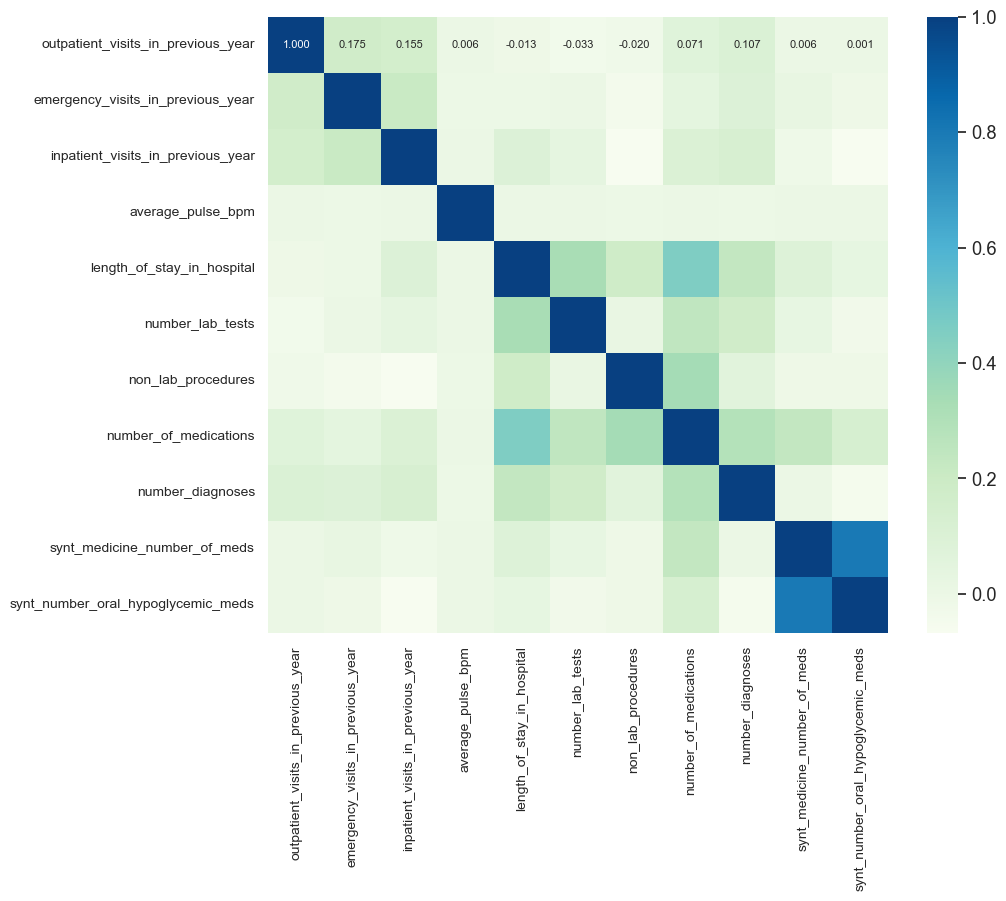

In [65]:
correlation_MC = X_train_num_MC.corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_MC, cmap='GnBu', annot=True, fmt=".3f", annot_kws={"size": 8},
            xticklabels=correlation_MC.columns, yticklabels=correlation_MC.columns)

# Adjust the font size of the labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

NOTES:<br>
<br>
<li>synt_medicine_number_of_meds and synt_number_oral_hypoglycemic_meds have a high correlation 0.801. I remove the first one because has higher correlation with features<br>
<br>
<li>Also number_of_medications and length_of_stay_in_hospital show a relevant correlation of 0.462.<br>
<br>
<li>average_pulse_bpm has almost not correlation with other features<br>
<br>




In [66]:
for i in ["synt_medicine_number_of_meds", "number_of_medications"]:
    lstvars_todrop_MC.append(i)

In [67]:
scaler_MC = MinMaxScaler()

X_train_num_MC_scaled = scaler_MC.fit_transform(X_train_num_MC)
X_val_num_MC_scaled = scaler_MC.transform(X_val_num_MC) 

In [68]:
X_val_num_MC_scaled = pd.DataFrame(X_val_num_MC_scaled, columns = X_val_num_MC.columns).set_index(X_val_MC.index)
X_train_num_MC_scaled = pd.DataFrame(X_train_num_MC_scaled, columns = X_train_num_MC.columns).set_index(X_train_MC.index)

#### Lasso Regression

I check the coefficients of the regression to see if some features are being negleted for the evaluation of the output.

Lasso Regression, Multiclass Target

In [69]:
reg1 = LassoCV()

In [70]:
y_train_MC_bin =  [0 if x == "No" else 1 if x == "<30 days" else 2 if x == ">30 days" else np.nan for x in y_train_MC]

reg1.fit(X_train_num_MC_scaled, y_train_MC_bin)

LassoCV()

In [71]:
coef1 = pd.Series(reg1.coef_, index = X_train_num_MC.columns)
coef1

outpatient_visits_in_previous_year    0.176274
emergency_visits_in_previous_year     0.166888
inpatient_visits_in_previous_year     0.575876
average_pulse_bpm                    -0.002098
length_of_stay_in_hospital            0.024090
number_lab_tests                      0.105656
non_lab_procedures                   -0.126756
number_of_medications                 0.000000
number_diagnoses                      0.504783
synt_medicine_number_of_meds          0.126579
synt_number_oral_hypoglycemic_meds    0.000000
dtype: float64

In [72]:
for a in coef1.index:
    if abs(coef1[a]) < 0.00005 :
        print(f"Lasso with a treshold of 0.0005 eliminates features '{a}'")
        lstvars_todrop_MC.append(a)


Lasso with a treshold of 0.0005 eliminates features 'number_of_medications'
Lasso with a treshold of 0.0005 eliminates features 'synt_number_oral_hypoglycemic_meds'


__RFE__

RFE,  Multiclass Target

In [73]:

#no of features
nof_list=np.arange(1, 10)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    
    X_train_rfe = rfe.fit_transform(X_train_num_MC_scaled,y_train_MC)
    X_val_rfe = rfe.transform(X_val_num_MC_scaled)
    
    model.fit(X_train_rfe,y_train_MC)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train_MC)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val_MC)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
        
        #adding mention of variables to keep
        features_to_select1 = pd.Series(rfe.support_, index = X_train_num_MC.columns)
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select1}")

Optimum number of features: 7
Score with 7 features: 0.569094
Features to select: 
outpatient_visits_in_previous_year     True
emergency_visits_in_previous_year      True
inpatient_visits_in_previous_year      True
average_pulse_bpm                     False
length_of_stay_in_hospital             True
number_lab_tests                      False
non_lab_procedures                    False
number_of_medications                 False
number_diagnoses                       True
synt_medicine_number_of_meds           True
synt_number_oral_hypoglycemic_meds     True
dtype: bool


In [74]:
for a in features_to_select1.index:
    
    if features_to_select[a] == False:
        
        lstvars_todrop_MC.append(a)

### Mutual Information 

A non-negative value that measures the mutual dependence between two random discrete variables

Mutual Information,  Multiclass Target

In [75]:
mutual_info = mutual_info_classif(X_train_num_MC, y_train_MC)

In [76]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_num_MC.columns
mutual_info.sort_values(ascending=False)

inpatient_visits_in_previous_year     0.025441
number_diagnoses                      0.009122
emergency_visits_in_previous_year     0.007857
outpatient_visits_in_previous_year    0.006592
non_lab_procedures                    0.003752
synt_medicine_number_of_meds          0.003423
number_of_medications                 0.002409
average_pulse_bpm                     0.002248
length_of_stay_in_hospital            0.001130
number_lab_tests                      0.000000
synt_number_oral_hypoglycemic_meds    0.000000
dtype: float64

In [77]:
for a in mutual_info.index:
    if abs(mutual_info[a]) < 0.00005 :
        print(f"Mutual Information with a treshold of 0.0005 discarcs '{a}'")
        lstvars_todrop_MC.append(a)

Mutual Information with a treshold of 0.0005 discarcs 'number_lab_tests'
Mutual Information with a treshold of 0.0005 discarcs 'synt_number_oral_hypoglycemic_meds'


<li> <b>3rd Step: Removing the features based on the tests </li>

In [78]:
lstvars_todrop_MC

['country',
 'synt_sec_diag_letter',
 'synt_add_diag_letter',
 'patient_id',
 'weightgroup',
 'specialty_mappings',
 'synt_pri_diag_subcode',
 'synt_sec_diag_subcode',
 'synt_add_diag_subcode',
 'weightgroup',
 'synt_medicine_number_of_meds',
 'number_of_medications',
 'number_of_medications',
 'synt_number_oral_hypoglycemic_meds',
 'outpatient_visits_in_previous_year',
 'average_pulse_bpm',
 'number_lab_tests',
 'synt_number_oral_hypoglycemic_meds']

In [79]:
filter_values(lstvars_todrop_MC, X_train_cat_MC, X_train_num_MC)

['country',
 'synt_sec_diag_letter',
 'synt_add_diag_letter',
 'patient_id',
 'weightgroup',
 'specialty_mappings',
 'synt_pri_diag_subcode',
 'synt_sec_diag_subcode',
 'synt_add_diag_subcode',
 'number_of_medications',
 'synt_number_oral_hypoglycemic_meds']

In [80]:
remove_features_MC( )

<a class="anchor" id="topic05" /> <br>
## Step 5 - Algorythm Chains/Pipeline: Column Transformers
[Back to Index](#index)

I wanted to have a method to chain several steps, ensuring that the output from one step worked consistently as input for the next step. The objective was to replace one part and have all the rest work seamlessly.

By implementing a pipeline, it became easier to move from one model to another without risking breaking the code. Pipelines, as the name suggests, join different "pipes" and ensure that data flows from start to finish without leaks.

Instead of invoking methods for several features, such as Imputers, Encoders, and Regressors, I assembled these elements in a pipeline. Then methods such as fit and transform are invoked at the pipeline level, hiding complexity and ensuring consistency. Column Transformers create a simple flow where I can encode features using several encoders after ensuring that null values are filled in using an imputer.

#### Bibliography: Introduction to Machine Learning with Python, Chapter 6, O'Reilly, Andreas C Muller, Sarah Guido


#### 5.1 Instantiate components used in the Pipeline/Column Transformer

Create the components to assemble the column transformer part of the pipeline


In [81]:

pipe_cat_non_ordinal= Pipeline(steps=[
     ('impute_mostfreq1', SimpleImputer(strategy='most_frequent')),
     ('encode_onehot1', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])


pipe_cat_ordinal= Pipeline(steps=[
    ('impute_mostfreq2', SimpleImputer(strategy='most_frequent')),
    ('label_encod2', OrdinalEncoder(handle_unknown='error')),
    ('scale_standard_num2', MinMaxScaler( feature_range=(0,1)))
])

pipe_numerical = Pipeline(steps=[
    ('impute_KNN3', KNNImputer()),
    ('scale_standard_num3', MinMaxScaler( feature_range=(0,1)))
])

pipe_binary = Pipeline(steps=[
    ('impute_mostfreq4', SimpleImputer(strategy='most_frequent'))
])



#### 5.2 Create the ColumnTransformer for the binary classifier, using the parts defined above

In [82]:
lst_coltransformers_BC = []

if len(lstvars_ordinal_cat_BC)>0:
    lst_coltransformers_BC.append(('pipe_cat_ordinal', pipe_cat_ordinal, lstvars_ordinal_cat_BC))
    vprint("Adding processing for ordinal features")
if len(lstvars_non_ordinal_cat_BC)>0:
    lst_coltransformers_BC.append(('pipe_cat_non_ordinal', pipe_cat_non_ordinal, lstvars_non_ordinal_cat_BC))
    vprint("Adding processing for non-ordinal features")
if len(lstvars_numerical_BC)>0:
    lst_coltransformers_BC.append(('pipe_numerical', pipe_numerical, lstvars_numerical_BC))
    vprint("Adding processing for numerical features")
if len(lstvars_binary_cat_BC)>0:
    lst_coltransformers_BC.append(('pipe_binary', pipe_binary, lstvars_binary_cat_BC))
    vprint("Adding processing for binary features")
    

col_trans_BC = ColumnTransformer(transformers=lst_coltransformers_BC, n_jobs=-1)


Adding processing for ordinal features
Adding processing for non-ordinal features
Adding processing for numerical features
Adding processing for binary features


#### 5.3 Create the ColumnTransformer for the multiclass classifier, using the parts defined above

In [83]:
lst_coltransformers_MC = []

if len(lstvars_ordinal_cat_MC)>0:
    lst_coltransformers_MC.append(('pipe_cat_ordinal', pipe_cat_ordinal, lstvars_ordinal_cat_MC))
    vprint("Adding processing for ordinal features")
    
if len(lstvars_non_ordinal_cat_MC)>0:
    lst_coltransformers_MC.append(('pipe_cat_non_ordinal', pipe_cat_non_ordinal, lstvars_non_ordinal_cat_MC))
    vprint("Adding processing for non-ordinal features")
if len(lstvars_numerical_MC)>0:
    lst_coltransformers_MC.append(('pipe_numerical', pipe_numerical, lstvars_numerical_MC))
    vprint("Adding processing for numerical features")
if len(lstvars_binary_cat_MC)>0:
    lst_coltransformers_MC.append(('pipe_binary', pipe_binary, lstvars_binary_cat_MC))
    vprint("Adding processing for binary features")

col_trans_MC = ColumnTransformer(transformers=lst_coltransformers_MC, n_jobs=-1)


Adding processing for ordinal features
Adding processing for non-ordinal features
Adding processing for numerical features
Adding processing for binary features


<a class="anchor" id="topic06" /> <br>
## Step 6 - Assessing several models with the data
[Back to Index](#index)

#### Step 6.1 - Binary classification - In this step, I am evaluating multiple models (using their default settings) in order to understand which models perform better with my data.

In [84]:
y_num_train_BC = [1 if x == "Yes" else 0 for x in y_train_BC]
y_num_val_BC   = [1 if x == "Yes" else 0 for x in y_val_BC]
y_num_trainval_BC = [1 if x == "Yes" else 0 for x in y_trainval_BC]

def get_default_models_BC():
    get_models_BC = dict()
    get_models_BC["ComplNB"] = build_pipeline(col_trans_BC, ComplementNB())
    get_models_BC["GaussNB"] = build_pipeline(col_trans_BC, GaussianNB())
    get_models_BC["DT"] = build_pipeline(col_trans_BC, DecisionTreeClassifier())
    get_models_BC["LogR"] = build_pipeline(col_trans_BC, LogisticRegression())
    get_models_BC["RF"] = build_pipeline(col_trans_BC, RandomForestClassifier(n_estimators=10, max_features="sqrt",
                                                min_samples_split=28, max_depth=22, class_weight='balanced_subsample'))
    get_models_BC["LinSVC"] = build_pipeline(col_trans_BC, LinearSVC())
    get_models_BC["GB"] = build_pipeline(col_trans_BC, GradientBoostingClassifier())
    get_models_BC["AdaBoost"] = build_pipeline(col_trans_BC, AdaBoostClassifier())
    get_models_BC["CatBoost"] = build_pipeline(col_trans_BC, CatBoostClassifier(verbose=0))
    
    return get_models_BC

models_BC = get_default_models_BC()


Mean scores, ComplNB : {'fit_time': 2.120440900325775, 'score_time': 0.809299498796463, 'test_f1': 0.2701904019549671, 'train_f1': 0.3037513480735087, 'test_f1_weighted': 0.7285033346328873, 'train_f1_weighted': 0.741852247231029, 'test_accuracy': 0.6691373801226543, 'train_accuracy': 0.6855116937058633, 'test_recall': 0.548892966298912, 'train_recall': 0.6147544361616444, 'test_precision': 0.17920619941559973, 'train_precision': 0.2017095225791731}
Mean scores, GaussNB : {'fit_time': 2.2883657217025757, 'score_time': 0.9726688861846924, 'test_f1': 0.2061208012763928, 'train_f1': 0.21878954089076008, 'test_f1_weighted': 0.1777945282109799, 'train_f1_weighted': 0.19031523278840762, 'test_accuracy': 0.1905123480787909, 'train_accuracy': 0.20309329535345538, 'test_recall': 0.9417133111870327, 'train_recall': 1.0, 'test_precision': 0.11572565227907236, 'train_precision': 0.12283209134344017}
Mean scores, DT : {'fit_time': 19.259647339582443, 'score_time': 0.6906425356864929, 'test_f1': 0.1

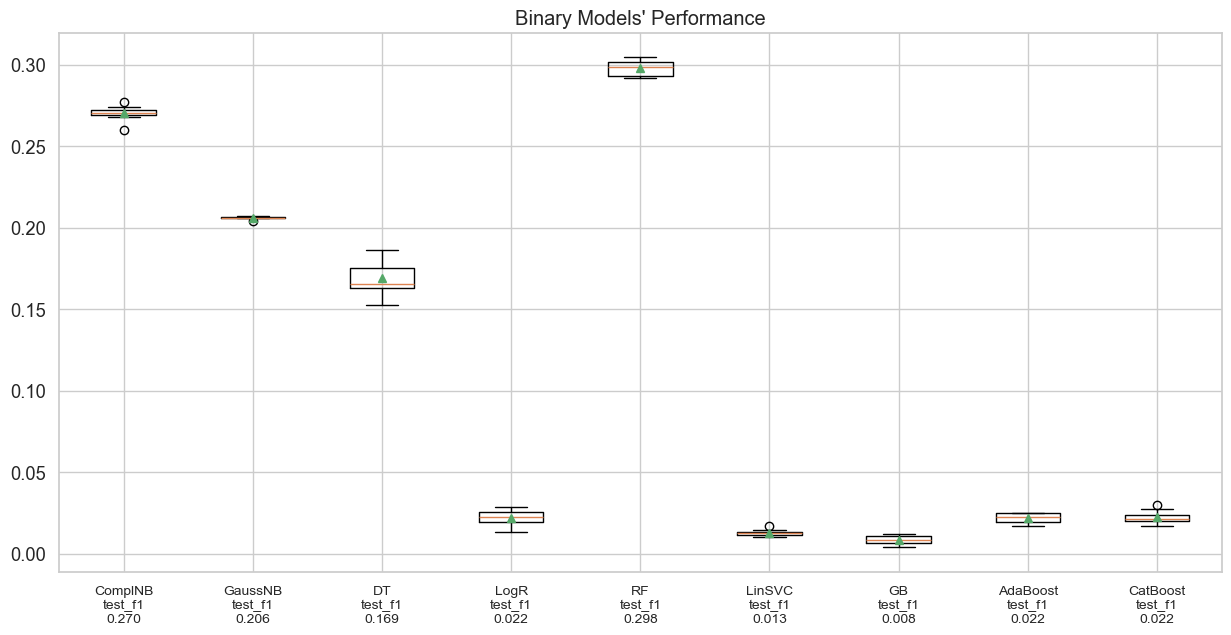

In [85]:
mod_results_BC, models_BC_base = myreturn_results_BC(models_BC, X_trainval_BC, y_num_trainval_BC, "Binary Models' Performance")

In [86]:
top_model_name_BC = get_best_model_name_by_metric(mod_results_BC, "test_f1")
top_model_BC = models_BC_base[top_model_name_BC]
top_model_BC.fit(X_trainval_BC, y_num_trainval_BC)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipe_cat_ordinal',
                                                  Pipeline(steps=[('impute_mostfreq2',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('label_encod2',
                                                                   OrdinalEncoder()),
                                                                  ('scale_standard_num2',
                                                                   MinMaxScaler())]),
                                                  ['agegroup']),
                                                 ('pipe_cat_non_ordinal',
                                                  Pipeline(steps=[('impute_mostfreq1',
                                                                   SimpleImputer(strategy='most_f...
                                                  Pipeline(steps=[('impute_mostfreq4',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['change_in_meds_during_hospitalization',
                                                   'prescribed_diabetes_meds',
                                                   'synt_medicine_insulin',
                                                   'tested_for_glucose',
                                                   'tested_for_a1c',
                                                   'same_patient'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=22, min_samples_split=28,
                                        n_estimators=10))])

In [87]:
y_train_01_BC = [1 if x == "Yes" else 0 for x in y_train_BC]
y_val_01_BC = [1 if x == "Yes" else 0 for x in y_val_BC]
y_test_01_BC = [1 if x == "Yes" else 0 for x in y_test_BC]

y_pred_train_BC = top_model_BC.predict(X_train_BC)
y_pred_val_BC = top_model_BC.predict(X_val_BC)
y_pred_test_BC = top_model_BC.predict(X_test_BC)

print( "Confusion Matrix for Train:\n", confusion_matrix(y_train_01_BC, y_pred_train_BC))
print( "Confusion Matrix for Validation:\n", confusion_matrix(y_val_01_BC, y_pred_val_BC))
print( "Confusion Matrix for Test:\n", confusion_matrix(y_test_01_BC, y_pred_test_BC))

Confusion Matrix for Train:
 [[24112  7583]
 [ 1458  2465]]
Confusion Matrix for Validation:
 [[12885  2885]
 [  990  1049]]
Confusion Matrix for Test:
 [[12772  3049]
 [ 1100   888]]


#### Step 6.2 - Multiclass classification - Same, but for the multiclass problem

In [88]:
y_train_012_MC = [0 if x == "No" else 1 if x == "<30 days" else 2 if x == ">30 days" else np.nan for x in y_train_MC]
y_val_012_MC   = [0 if x == "No" else 1 if x == "<30 days" else 2 if x == ">30 days" else np.nan for x in y_val_MC]
y_trainval_012_MC = [0 if x == "No" else 1 if x == "<30 days" else 2 if x == ">30 days" else np.nan for x in y_trainval_MC]

def get_default_models_MC():
    get_models_MC = dict()
    get_models_MC["ComplNB"] = build_pipeline(col_trans_MC, ComplementNB())
    get_models_MC["GaussNB"] = build_pipeline(col_trans_MC, GaussianNB())
    get_models_MC["DT"] = build_pipeline(col_trans_MC, DecisionTreeClassifier())
    get_models_MC["LogR"] = build_pipeline(col_trans_MC, LogisticRegression())
    get_models_MC["RF"] = build_pipeline(col_trans_MC, RandomForestClassifier(n_estimators=10, max_features="sqrt",
                                                                              min_samples_split=28, max_depth=22))
    get_models_MC["LinSVC"] = build_pipeline(col_trans_MC, LinearSVC())
    get_models_MC["GB"] = build_pipeline(col_trans_MC, GradientBoostingClassifier())
    get_models_MC["AdaBoost"] = build_pipeline(col_trans_MC, AdaBoostClassifier())
    get_models_MC["CatBoost"] = build_pipeline(col_trans_MC, CatBoostClassifier(verbose=0))
    
    return get_models_MC

models_MC = get_default_models_MC()


Mean scores, ComplNB : {'fit_time': 1.7514554262161255, 'score_time': 0.676005631685257, 'test_f1': nan, 'train_f1': nan, 'test_f1_weighted': 0.5795520099754525, 'train_f1_weighted': 0.6077294871783707, 'test_accuracy': 0.58799858827625, 'train_accuracy': 0.6155002856110837, 'test_recall': nan, 'train_recall': nan, 'test_precision': nan, 'train_precision': nan}
Mean scores, GaussNB : {'fit_time': 2.387321501970291, 'score_time': 1.0960353016853333, 'test_f1': nan, 'train_f1': nan, 'test_f1_weighted': 0.11431598258405748, 'train_f1_weighted': 0.14173725573298976, 'test_accuracy': 0.1553802759311566, 'train_accuracy': 0.17600651601393552, 'test_recall': nan, 'train_recall': nan, 'test_precision': nan, 'train_precision': nan}
Mean scores, DT : {'fit_time': 8.852295070886612, 'score_time': 0.7004447877407074, 'test_f1': nan, 'train_f1': nan, 'test_f1_weighted': 0.5571646142294171, 'train_f1_weighted': 0.9999032922071298, 'test_accuracy': 0.5623561585642807, 'train_accuracy': 0.999903294857

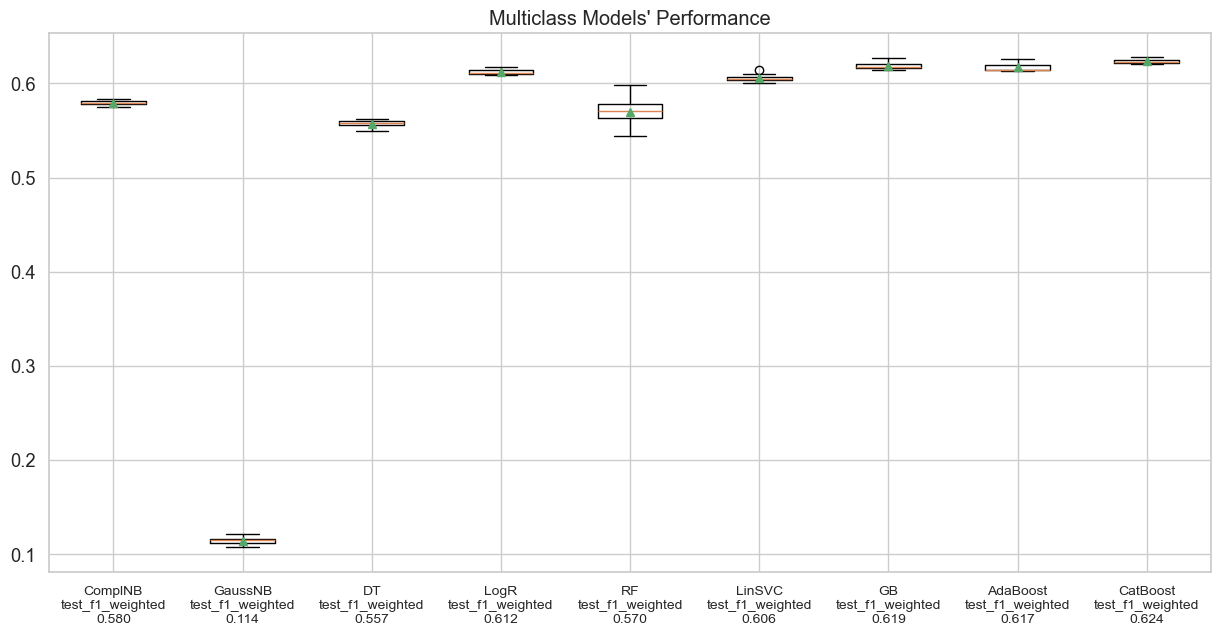

In [89]:
mod_results_MC, models_MC = myreturn_results_MC(models_MC, X_trainval_MC, y_trainval_012_MC, "Multiclass Models' Performance", boxplot=["test_f1_weighted"])

In [90]:
top_model_name_MC = get_best_model_name_by_metric(mod_results_MC, "test_f1_weighted")
top_model_MC = models_MC[top_model_name_MC]
top_model_MC.fit(X_trainval_MC, y_trainval_012_MC)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipe_cat_ordinal',
                                                  Pipeline(steps=[('impute_mostfreq2',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('label_encod2',
                                                                   OrdinalEncoder()),
                                                                  ('scale_standard_num2',
                                                                   MinMaxScaler())]),
                                                  ['agegroup']),
                                                 ('pipe_cat_non_ordinal',
                                                  Pipeline(steps=[('impute_mostfreq1',
                                                                   SimpleImputer(strategy='most_f...
                                                   'number_diagnoses']),
                                                 ('pipe_binary',
                                                  Pipeline(steps=[('impute_mostfreq4',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['isfemale',
                                                   'change_in_meds_during_hospitalization',
                                                   'prescribed_diabetes_meds',
                                                   'synt_medicine_insulin',
                                                   'tested_for_glucose',
                                                   'tested_for_a1c',
                                                   'same_patient'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000001B55265C750>)])

In [91]:
y_train_01_MC = [0 if x == "No" else 1 if x == "<30 days" else 2 if x == ">30 days" else np.nan for x in y_train_MC]
y_val_01_MC = [0 if x == "No" else 1 if x == "<30 days" else 2 if x == ">30 days" else np.nan for x in y_val_MC]
y_test_01_MC = [0 if x == "No" else 1 if x == "<30 days" else 2 if x == ">30 days" else np.nan for x in y_test_MC]

y_pred_train_MC = top_model_MC.predict(X_train_MC)
y_pred_val_MC = top_model_MC.predict(X_val_MC)
y_pred_test_MC = top_model_MC.predict(X_test_MC)

print( "Confusion Matrix for Train:\n", confusion_matrix(y_train_01_MC, y_pred_train_MC))
print( "Confusion Matrix for Validation:\n", confusion_matrix(y_val_01_MC, y_pred_val_MC))
print( "Confusion Matrix for Test:\n", confusion_matrix(y_test_01_MC, y_pred_test_MC))

Confusion Matrix for Train:
 [[17294    25  1885]
 [ 1810   171  1992]
 [ 6415    50  5976]]
Confusion Matrix for Validation:
 [[8894   16  690]
 [1169   73  747]
 [3926   22 2272]]
Confusion Matrix for Test:
 [[8773   10  818]
 [1133   47  808]
 [4040   30 2150]]


<a class="anchor" id="topic07" /> <br>
## Step 7 - Optimized search for the ideal Hyperparameter
[Back to Index](#index)

### 7.1 Define Functions and dictionaries for Randomized and for GridSearch

#### This function receives a parameter_value obtained from randomized search, and optionally a delta value and a list to append if the parameter_value is None.
It returns a list with values from parameter_value - 2 * delta to parameter_value + 2 * delta, with step delta<br>
If parameter_value is None, returns it with the list of values to append<br>
For string values, returns just the string.

In [92]:
def getSearchRange( bestparams_value, deltaval = None, append_list_if_none = [], search_accellerator=1):
	retRange = []
	if bestparams_value is None:
		retRange = [None] + append_list_if_none
	else:
		if type(bestparams_value) in [int, float]:
			if deltaval is None:
				deltaval = 2
			else:
				deltaval = deltaval/2
			if type(bestparams_value) == int:
				deltaval = int(deltaval + 0.5)
			retRange = np.arange(max(0, bestparams_value - 2*deltaval), bestparams_value + 2*deltaval, deltaval * search_accellerator)
		if type(bestparams_value) == str or type(bestparams_value) == bool:
			retRange = [bestparams_value]
	
	return retRange

Dictionary for Randomized Search

In [93]:
#Defining the parameter space in which to search for the best parameter

param_space_randsearch = dict()

param_space_randsearch["CategNB"] = {
    'classifier__alpha': [0.1, 0.2, 0.5, 1.0],
    'classifier__force_alpha': [True, False],
    'classifier__fit_prior': [True, False],
    'classifier__min_categories': [None, 2, 5, 10]
}

param_space_randsearch["ComplNB"] = {
    "classifier__alpha": [0.0, 0.1, 0.2, 0.5, 1.0]
}

param_space_randsearch["DT"] = {
    'classifier__max_depth': [None] + list(range(5, 21, 3)), 
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__n_estimators':  range(10,200,25), 
    'classifier__min_samples_leaf':[1, 2, 3, 4, 5],
    'classifier__max_features': ['sqrt', 0.5, 0.2, None, 'log2'],
    'classifier__max_leaf_nodes': [None] + list(range(80, 100, 5)),
    'classifier__bootstrap': [True], 
    'classifier__max_samples': [None, 0.6, 0.7, 0.8, 0.9, 1]
    }

param_space_randsearch["GaussNB"] = {
    'classifier__var_smoothing': [0.1, 0.01, 0.001, 0.0001, 1]
    }

param_space_randsearch["LinSVC"] = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-3, 1e-4, 1e-5],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__multi_class': ['ovr', 'crammer_singer'],
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': [1000, 2000, 3000]
}

param_space_randsearch["LogR"] = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__fit_intercept': [True, False],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter': [50, 100, 200],
    'classifier__multi_class': ['auto', 'ovr', 'multinomial']
}

param_space_randsearch["RF"] = {
    'classifier__max_depth': [None] + list(range(5, 25, 3)),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__n_estimators':  range(10,200,25), 
    'classifier__min_samples_leaf':[3, 5, 7],
    'classifier__max_features': ['sqrt', 0.5, 0.2, None, 'log2'],
    'classifier__max_leaf_nodes': [None] + list(range(50, 200, 5)),
    'classifier__bootstrap': [True], 
    'classifier__max_samples': [None, 0.4, 0.6, 0.8, 1.0]
    }

param_space_randsearch["GB"] = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__n_estimators': range(50, 300, 50),
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_depth': [3, 5, 7, 9],
}

param_space_randsearch["AdaBoost"] = {
    'classifier__n_estimators': range(50, 300, 50),
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
}

param_space_randsearch["CatBoost"] = {
    'classifier__iterations': [100, 200, 500],
    'classifier__depth': [4, 6, 8, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__l2_leaf_reg': [3, 5, 7, 9],
}



Dictionary for Grid Search, implemented as a function<br>
For grid search, I need to pass the dictionary with the best parameters, and use it as a starting point to perform the grid search.<br>

In [94]:
def getGridSearchParams(best_params):
    gridDict = {}
    best_params_keys = best_params.keys()

    # If the number of keys in dictionary best_params whose values are numeric is 3 or more
    # I will increase the step size for the grid search
    if len([x for x in best_params_keys if isinstance(best_params[x], (int, float))]) >= 3:
        search_accellerator = 2
    else:
        search_accellerator = 1

    if "classifier__alpha" in best_params_keys:
        gridDict["classifier__alpha"] = [best_params["classifier__alpha"]]

    if "classifier__max_features" in best_params_keys:
        # If it's float, keep it as float; if it's integer or string, keep it as such
        if isinstance(best_params["classifier__max_features"], (int, str)):
            gridDict["classifier__max_features"] = getSearchRange(best_params["classifier__max_features"], search_accellerator=search_accellerator)
        elif isinstance(best_params["classifier__max_features"], float):
            minval = max(0.1, best_params["classifier__max_features"] - 0.2)
            maxval = min(1.0, best_params["classifier__max_features"] + 0.2)
            gridDict["classifier__max_features"] = [minval, best_params["classifier__max_features"], maxval]

    if "classifier__max_depth" in best_params_keys:
        gridDict["classifier__max_depth"] = getSearchRange(best_params["classifier__max_depth"], append_list_if_none=list(range(3, 14, int(5 * search_accellerator))), deltaval=2, search_accellerator=search_accellerator)

    if "classifier__max_samples" in best_params_keys:
        gridDict["classifier__max_samples"] = [best_params["classifier__max_samples"]]

    if "classifier__algorithm" in best_params_keys:
        gridDict["classifier__algorithm"] = getSearchRange(best_params["classifier__algorithm"], search_accellerator=search_accellerator)

    if "classifier__bootstrap" in best_params_keys:
        gridDict["classifier__bootstrap"] = getSearchRange(best_params["classifier__bootstrap"], search_accellerator=search_accellerator)

    if "classifier__C" in best_params_keys:
        gridDict["classifier__C"] = getSearchRange(best_params["classifier__C"], search_accellerator=search_accellerator)

    if "classifier__criterion" in best_params_keys:
        gridDict["classifier__criterion"] = getSearchRange(best_params["classifier__criterion"], search_accellerator=search_accellerator)

    if "classifier__dual" in best_params_keys:
        gridDict["classifier__dual"] = getSearchRange(best_params["classifier__dual"], search_accellerator=search_accellerator)

    if "classifier__fit_intercept" in best_params_keys:
        gridDict["classifier__fit_intercept"] = getSearchRange(best_params["classifier__fit_intercept"], search_accellerator=search_accellerator)

    if "classifier__force_alpha" in best_params_keys:
        gridDict["classifier__force_alpha"] = getSearchRange(best_params["classifier__force_alpha"])

    if "classifier__fit_prior" in best_params_keys:
        gridDict["classifier__fit_prior"] = getSearchRange(best_params["classifier__fit_prior"], search_accellerator=search_accellerator)

    if "classifier__leaf_size" in best_params_keys:
        gridDict["classifier__leaf_size"] = getSearchRange(best_params["classifier__leaf_size"], search_accellerator=search_accellerator)

    if "classifier__loss" in best_params_keys:
        gridDict["classifier__loss"] = getSearchRange(best_params["classifier__loss"], search_accellerator=search_accellerator)

    if "classifier__max_iter" in best_params_keys:
        gridDict["classifier__max_iter"] = getSearchRange(best_params["classifier__max_iter"], search_accellerator=search_accellerator)

    if "classifier__max_leaf_nodes" in best_params_keys:
        gridDict["classifier__max_leaf_nodes"] = getSearchRange(best_params["classifier__max_leaf_nodes"], append_list_if_none=list(range(80, 101, 10 * search_accellerator)), search_accellerator=search_accellerator)

    if "classifier__metric" in best_params_keys:
        gridDict["classifier__metric"] = getSearchRange(best_params["classifier__metric"], search_accellerator=search_accellerator)

    if "classifier__min_categories" in best_params_keys:
        gridDict["classifier__min_categories"] = getSearchRange(best_params["classifier__min_categories"], search_accellerator=search_accellerator)

    if "classifier__min_samples_leaf" in best_params_keys:
        gridDict["classifier__min_samples_leaf"] = [x for x in getSearchRange(best_params["classifier__min_samples_leaf"], search_accellerator=search_accellerator) if x >= 1]

    if "classifier__multi_class" in best_params_keys:
        gridDict["classifier__multi_class"] = getSearchRange(best_params["classifier__multi_class"], search_accellerator=search_accellerator)

    if "classifier__n_estimators" in best_params_keys:
        gridDict["classifier__n_estimators"] = getSearchRange(best_params["classifier__n_estimators"], search_accellerator=search_accellerator)

    if "classifier__n_neighbors" in best_params_keys:
        gridDict["classifier__n_neighbors"] = getSearchRange(best_params["classifier__n_neighbors"], search_accellerator=search_accellerator)

    if "classifier__p" in best_params_keys:
        gridDict["classifier__p"] = getSearchRange(best_params["classifier__p"], search_accellerator=search_accellerator)

    if "classifier__penalty" in best_params_keys:
        gridDict["classifier__penalty"] = getSearchRange(best_params["classifier__penalty"], search_accellerator=search_accellerator)

    if "classifier__solver" in best_params_keys:
        gridDict["classifier__solver"] = getSearchRange(best_params["classifier__solver"], search_accellerator=search_accellerator)

    if "classifier__tol" in best_params_keys:
        gridDict["classifier__tol"] = getSearchRange(best_params["classifier__tol"], search_accellerator=search_accellerator)

    if "classifier__var_smoothing" in best_params_keys:
        gridDict["classifier__var_smoothing"] = getSearchRange(best_params["classifier__var_smoothing"], append_list_if_none=[0.1, 0.001], search_accellerator=search_accellerator)

    if "classifier__weights" in best_params_keys:
        gridDict["classifier__weights"] = getSearchRange(best_params["classifier__weights"], search_accellerator=search_accellerator)

    if "classifier__learning_rate" in best_params_keys:
      gridDict["classifier__learning_rate"] = [best_params["classifier__learning_rate"]]

    if "classifier__subsample" in best_params_keys:
        gridDict["classifier__subsample"] = getSearchRange(best_params["classifier__subsample"], search_accellerator=search_accellerator)

    if "classifier__min_samples_split" in best_params_keys:
        gridDict["classifier__min_samples_split"] = getSearchRange(best_params["classifier__min_samples_split"], search_accellerator=search_accellerator)

    if "classifier__iterations" in best_params_keys:
        gridDict["classifier__iterations"] = getSearchRange(best_params["classifier__iterations"], search_accellerator=search_accellerator)

    if "classifier__depth" in best_params_keys:
        gridDict["classifier__depth"] = getSearchRange(best_params["classifier__depth"], search_accellerator=search_accellerator)

    if "classifier__l2_leaf_reg" in best_params_keys:
        gridDict["classifier__l2_leaf_reg"] = getSearchRange(best_params["classifier__l2_leaf_reg"], search_accellerator=search_accellerator)

    if "classifier__random_state" in best_params_keys:
        gridDict["classifier__random_state"] = best_params["classifier__random_state"]
    
    if "classifier__random_state" in best_params_keys:
        gridDict["classifier__random_state"] = best_params["classifier__random_state"]

    return gridDict


### 7.2 Checking performance using cross-validation (KFold)
KFold performs several splits on the data, creating train and validation datasets, and then
evaluates the model performance for train/validation and returns the averaged result.
This makes the performance evaluation less dependent on the actual data split that was performed.

As KFold already splits data, I am using all data, not the separate train and validation splits. This would result in only the train data being actually used.

In [145]:
avg_score_BC(split_method, X_train_BC, y_train_BC, top_model_BC)


Train average score:0.373+/-0.008
Val average score:0.287+/-0.005
Overfitting abs(Train-Val):0.086


In [146]:
avg_score_MC(split_method, X_train_MC, y_train_MC, top_model_MC)

Train average score:0.709+/-0.001
Val average score:0.686+/-0.002
Overfitting abs(Train-Val):0.022


### 7.3 - Binary Classification -  Use RandomizedSearchCV to get good ballpark values for hyperparameters

#### Binary Classification

In [97]:
model_family_BC = top_model_name_BC.split(" ")[0]
print(model_family_BC)
dictRandSearchParams_BC = param_space_randsearch[model_family_BC]
print(dictRandSearchParams_BC)

randsearch_BC = RandomizedSearchCV(top_model_BC, param_distributions=dictRandSearchParams_BC, n_iter=10, scoring='f1', n_jobs=-1)

RF
{'classifier__max_depth': [None, 5, 8, 11, 14, 17, 20, 23], 'classifier__criterion': ['gini', 'entropy'], 'classifier__n_estimators': range(10, 200, 25), 'classifier__min_samples_leaf': [3, 5, 7], 'classifier__max_features': ['sqrt', 0.5, 0.2, None, 'log2'], 'classifier__max_leaf_nodes': [None, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195], 'classifier__bootstrap': [True], 'classifier__max_samples': [None, 0.4, 0.6, 0.8, 1.0]}


In [98]:
randsearch_BC.fit(X_train_BC, y_train_BC)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('pipe_cat_ordinal',
                                                                               Pipeline(steps=[('impute_mostfreq2',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('label_encod2',
                                                                                                OrdinalEncoder()),
                                                                                               ('scale_standard_num2',
                                                                                                MinMaxScaler())]),
                                                                               ['agegroup']),
                                                                              ('pipe_cat_non_ordinal',
                                                                               Pipeline(steps=[('impute_mostfreq1',
                                                                                                S...
                                                                  20, 23],
                                        'classifier__max_features': ['sqrt',
                                                                     0.5, 0.2,
                                                                     None,
                                                                     'log2'],
                                        'classifier__max_leaf_nodes': [None, 50,
                                                                       55, 60,
                                                                       65, 70,
                                                                       75, 80,
                                                                       85, 90,
                                                                       95, 100,
                                                                       105, 110,
                                                                       115, 120,
                                                                       125, 130,
                                                                       135, 140,
                                                                       145, 150,
                                                                       155, 160,
                                                                       165, 170,
                                                                       175, 180,
                                                                       185, 190, ...],
                                        'classifier__max_samples': [None, 0.4,
                                                                    0.6, 0.8,
                                                                    1.0],
                                        'classifier__min_samples_leaf': [3, 5,
                                                                         7],
                                        'classifier__n_estimators': range(10, 200, 25)},
                   scoring='f1')

In [99]:
bestparams_rand_BC = randsearch_BC.best_params_
bestparams_rand_BC


{'classifier__n_estimators': 185,
 'classifier__min_samples_leaf': 3,
 'classifier__max_samples': 0.4,
 'classifier__max_leaf_nodes': 185,
 'classifier__max_features': None,
 'classifier__max_depth': 8,
 'classifier__criterion': 'gini',
 'classifier__bootstrap': True}

### Step 7.4 - Multiclass classification - Same, but for the multiclass problem

In [100]:
model_family_MC = top_model_name_MC.split(" ")[0]
print(model_family_MC)
dictRandSearchParams_MC = param_space_randsearch[model_family_MC]
print(dictRandSearchParams_MC)

randsearch_MC = RandomizedSearchCV(top_model_MC, param_distributions=dictRandSearchParams_MC, n_iter=10, scoring='f1_weighted', n_jobs=-1, random_state= g_random_state, verbose=g_verbose_models, cv=3)

CatBoost
{'classifier__iterations': [100, 200, 500], 'classifier__depth': [4, 6, 8, 10], 'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2], 'classifier__l2_leaf_reg': [3, 5, 7, 9]}


In [101]:
randsearch_MC.fit(X_train_MC, y_train_MC)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                transformers=[('pipe_cat_ordinal',
                                                                               Pipeline(steps=[('impute_mostfreq2',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('label_encod2',
                                                                                                OrdinalEncoder()),
                                                                                               ('scale_standard_num2',
                                                                                                MinMaxScaler())]),
                                                                               ['agegroup']),
                                                                              ('pipe_cat_non_ordinal',
                                                                               Pipeline(steps=[('impute_mostfre...
                                                                                'tested_for_glucose',
                                                                                'tested_for_a1c',
                                                                                'same_patient'])])),
                                             ('classifier',
                                              <catboost.core.CatBoostClassifier object at 0x000001B55265C750>)]),
                   n_jobs=-1,
                   param_distributions={'classifier__depth': [4, 6, 8, 10],
                                        'classifier__iterations': [100, 200,
                                                                   500],
                                        'classifier__l2_leaf_reg': [3, 5, 7, 9],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.2]},
                   random_state=53, scoring='f1_weighted', verbose=3)

In [102]:
bestparams_rand_MC = randsearch_MC.best_params_
bestparams_rand_MC

{'classifier__learning_rate': 0.2,
 'classifier__l2_leaf_reg': 3,
 'classifier__iterations': 200,
 'classifier__depth': 8}

### 7.5 GridSearchCV using the approximate values found in the previous step, fine-tune the Hyperparameters

#### 7.5.1 Binary Classification

In [103]:
print("BC: Best parameters obtained using RandomizedSearch:",bestparams_rand_BC)

dictGridSearchParams_BC = getGridSearchParams( bestparams_rand_BC)
print("Parameters to try using GridSearch:", dictGridSearchParams_BC)

gridsearch_BC = GridSearchCV(top_model_BC, dictGridSearchParams_BC, scoring='f1', return_train_score=True, cv=3, verbose=g_verbose_models, n_jobs=-1)


BC: Best parameters obtained using RandomizedSearch: {'classifier__n_estimators': 185, 'classifier__min_samples_leaf': 3, 'classifier__max_samples': 0.4, 'classifier__max_leaf_nodes': 185, 'classifier__max_features': None, 'classifier__max_depth': 8, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Parameters to try using GridSearch: {'classifier__max_depth': array([6, 8]), 'classifier__max_samples': [0.4], 'classifier__bootstrap': [True], 'classifier__criterion': ['gini'], 'classifier__max_leaf_nodes': array([181, 185]), 'classifier__min_samples_leaf': [4], 'classifier__n_estimators': array([181, 185])}


In [104]:
gridsearch_BC.fit(X_train_BC, y_train_BC)

print("Best parameters obtained using GridSearch:", gridsearch_BC.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters obtained using GridSearch: {'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_leaf_nodes': 181, 'classifier__max_samples': 0.4, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 181}


#### 7.5.2 Multiclass Classification

In [105]:
print("MC: Best parameters obtained using RandomizedSearch:",bestparams_rand_MC)

dictGridSearchParams_MC = getGridSearchParams( bestparams_rand_MC)
print("Parameters to try using GridSearch:", dictGridSearchParams_MC)


gridsearch_MC = GridSearchCV(top_model_MC, dictGridSearchParams_MC, scoring='f1_weighted', return_train_score=True, verbose=g_verbose_models, cv=3)

MC: Best parameters obtained using RandomizedSearch: {'classifier__learning_rate': 0.2, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 200, 'classifier__depth': 8}
Parameters to try using GridSearch: {'classifier__learning_rate': [0.2], 'classifier__iterations': array([196, 200]), 'classifier__depth': array([4, 8]), 'classifier__l2_leaf_reg': array([0, 4])}


In [106]:
gridsearch_MC.fit(X_train_MC, y_train_MC)

print("Best parameters obtained using GridSearch:", gridsearch_MC.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END classifier__depth=4, classifier__iterations=196, classifier__l2_leaf_reg=0, classifier__learning_rate=0.2;, score=(train=0.612, test=0.598) total time=  14.2s
[CV 2/3] END classifier__depth=4, classifier__iterations=196, classifier__l2_leaf_reg=0, classifier__learning_rate=0.2;, score=(train=0.615, test=0.597) total time=  13.8s
[CV 3/3] END classifier__depth=4, classifier__iterations=196, classifier__l2_leaf_reg=0, classifier__learning_rate=0.2;, score=(train=0.616, test=0.595) total time=  13.4s
[CV 1/3] END classifier__depth=4, classifier__iterations=196, classifier__l2_leaf_reg=4, classifier__learning_rate=0.2;, score=(train=0.600, test=0.598) total time=  13.7s
[CV 2/3] END classifier__depth=4, classifier__iterations=196, classifier__l2_leaf_reg=4, classifier__learning_rate=0.2;, score=(train=0.602, test=0.597) total time=  13.6s
[CV 3/3] END classifier__depth=4, classifier__iterations=196, classifier__l2_lea

### 7.6 Best Parameters for the model

Binary Classification

In [109]:
print("Binary classification, best parameters using RandomizedSearchCV\n{}".format( randsearch_BC.best_params_))
print("Binary classification, best parameters using GridSearchCV\n{}".format( gridsearch_BC.best_params_))

best_model_BC = []
best_model_BC.append(('best_GS_BC',gridsearch_BC.best_estimator_))

Binary classification, best parameters using RandomizedSearchCV
{'classifier__n_estimators': 185, 'classifier__min_samples_leaf': 3, 'classifier__max_samples': 0.4, 'classifier__max_leaf_nodes': 185, 'classifier__max_features': None, 'classifier__max_depth': 8, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Binary classification, best parameters using GridSearchCV
{'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_leaf_nodes': 181, 'classifier__max_samples': 0.4, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 181}


Multiclass Classification

In [110]:
print("Multiclass classification, best parameters using RandomizedSearchCV\n{}".format( randsearch_MC.best_params_))
print("Multiclass classification, best parameters using GridSearchCV\n{}".format( gridsearch_MC.best_params_))

best_model_MC = []
best_model_MC.append(('best_GS_MC',gridsearch_MC.best_estimator_))

Multiclass classification, best parameters using RandomizedSearchCV
{'classifier__learning_rate': 0.2, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 200, 'classifier__depth': 8}
Multiclass classification, best parameters using GridSearchCV
{'classifier__depth': 8, 'classifier__iterations': 196, 'classifier__l2_leaf_reg': 4, 'classifier__learning_rate': 0.2}


<a class="anchor" id="topic8" /> <br>
# 8 - Final Models and Prediction on Test Set
[Back to Index](#index)


Binary Classification

In [163]:
# Access the first tuple in the list best_model_BC
final_model_name_BC, final_model_BC = best_model_BC[0]

# Record the start time
time_start = datetime.datetime.now()

# Print the model name
print("-- Model: ", final_model_name_BC)

# Perform the scoring using avg_score_BC function
avg_final_score_BC(split_method, X_trainval_BC, y_trainval_BC, final_model_BC)

# Record the end time
time_end = datetime.datetime.now()

# Calculate and print the elapsed time in seconds
print("Elapsed seconds: ", (time_end - time_start).seconds)
print("-------------------------------------\n")


-- Model:  best_GS_BC
Train average score:0.315+/-0.004
Test average score:0.305+/-0.007
Overfitting abs(Train-Test):0.01
Elapsed seconds:  102
-------------------------------------



Multiclass Classification

In [164]:
# Access the first tuple in the list best_model_MC
final_model_name_MC, final_model_MC = best_model_MC[0]

# Record the start time
time_start = datetime.datetime.now()

# Print the model name
print("-- Model: ", final_model_name_MC)

# Perform the scoring using avg_score_BC function
avg_final_score_MC(split_method, X_trainval_MC, y_trainval_MC, final_model_MC)

# Record the end time
time_end = datetime.datetime.now()

# Calculate and print the elapsed time in seconds
print("Elapsed seconds: ", (time_end - time_start).seconds)
print("-------------------------------------\n")

-- Model:  best_GS_MC
Train average score:0.719+/-0.001
Test average score:0.702+/-0.003
Overfitting abs(Train-Test):0.017
Elapsed seconds:  350
-------------------------------------

